Analyse de données du lab 4 de TPA. Électrolyse de l'eau.


In [134]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as spicy

from scipy.optimize import curve_fit, root_scalar

# Configuration de la police (désactiver explicitement LaTeX)
plt.rcParams.update({
    "text.usetex": False,
    "axes.labelsize": 24,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "legend.fontsize": 20,
    "font.family": "DejaVu Serif"
})

In [135]:
# Données expérimentales d'électrolyse

E_vol_H2 = 10.0926 #J/ml

electrodes = [
    'Laiton',
    'Cuivre- Carbon+ V2',
    'Aluminium',
    'Stainless',
    'Stainless (concentration++)',
    'Carbone',
    'Titane',
    'Titane- carbone+'
]

# Données mesurées
concentration_NaHCO3 = [1.81e-2, 1.81e-2, 1.81e-2, 1.81e-2, 0.044928193 , 1.81e-2, 1.81e-2, 1.81e-2]
courant_stable = [0.52, 0.52, 0.545, 0.63, 1.5, 0.6, 0.014, 0.5]  # [A]
tension_stable = [10, 10, 10, 10, 10, 10, 30.9, 10.01]  # [V]
temps = [592, 550, 519, 400, 121, 390, 1260, 715]  # [s]
volume_H2 = [42, 40, 41, 34, 30, 32, 0.5, 47]  # [ml]
volume_O2 = [17, 15, 16, 8, 14, 18, 0.5, 23]  # [ml]
surface_anode = [1.532627e-4, 1.532627e-4, 1.532627e-4, 1.532627e-4, 1.532627e-4, 1.532627e-4, 1.395570e-4, 1.508405e-4]  # [m²]
surface_cathode = [8.353691e-5, 8.154200e-5, 8.353691e-5, 9.949620e-5, 1.034860e-4, 1.034860e-4, 1.195570e-4, 1.395570e-4]  # [m²]

# Créer un DataFrame pour faciliter l'analyse
data = {
    'Électrodes': electrodes,
    'Concentration NaHCO₃ [g/g]': concentration_NaHCO3,
    'Courant [A]': courant_stable,
    'Tension [V]': tension_stable,
    'Temps [s]': temps,
    'Volume H₂ [ml]': volume_H2,
    'Volume O₂ [ml]': volume_O2,
    'Surface anode [m²]': surface_anode,
    'Surface cathode [m²]': surface_cathode
}

df = pd.DataFrame(data)

# Calculs dérivés
df['Puissance [W]'] = df['Courant [A]'] * df['Tension [V]']
df['Énergie [J]'] = df['Puissance [W]'] * df['Temps [s]']
df['Taux H₂ [ml/s]'] = df['Volume H₂ [ml]'] / df['Temps [s]']
df['Taux O₂ [ml/s]'] = df['Volume O₂ [ml]'] / df['Temps [s]']
df['Ratio H₂/O₂'] = df['Volume H₂ [ml]'] / df['Volume O₂ [ml]']
df['Efficacité [ml H₂/Wh]'] = (df['Volume H₂ [ml]'] / df['Énergie [J]']) * 3600
df['Résistance [Ω]'] = df['Tension [V]'] / df['Courant [A]']

# Afficher le tableau
print("="*120)
print("DONNÉES EXPÉRIMENTALES - ÉLECTROLYSE DE L'EAU")
print("="*120)
print(df.to_string(index=False))
print("\n" + "="*120)
print("Données importées avec succès!")
print(f"Nombre de configurations: {len(df)}")
print("="*120)

DONNÉES EXPÉRIMENTALES - ÉLECTROLYSE DE L'EAU
                 Électrodes  Concentration NaHCO₃ [g/g]  Courant [A]  Tension [V]  Temps [s]  Volume H₂ [ml]  Volume O₂ [ml]  Surface anode [m²]  Surface cathode [m²]  Puissance [W]  Énergie [J]  Taux H₂ [ml/s]  Taux O₂ [ml/s]  Ratio H₂/O₂  Efficacité [ml H₂/Wh]  Résistance [Ω]
                     Laiton                    0.018100        0.520        10.00        592            42.0            17.0            0.000153              0.000084         5.2000     3078.400        0.070946        0.028716     2.470588              49.116424       19.230769
         Cuivre- Carbon+ V2                    0.018100        0.520        10.00        550            40.0            15.0            0.000153              0.000082         5.2000     2860.000        0.072727        0.027273     2.666667              50.349650       19.230769
                  Aluminium                    0.018100        0.545        10.00        519            41.0         

## Analyse 1 : Comparaison des électrodes principales

Sélection des configurations pour la première analyse comparative.

In [142]:
# Sélection des électrodes pour l'analyse 1
electrodes_analyse1 = [
    'Laiton',
    'Cuivre- Carbon+ V2',
    'Aluminium',
    'Stainless',
    'Carbone',
        'Titane- carbone+'
]

# Filtrer le DataFrame pour ne garder que ces configurations
df_analyse1 = df[df['Électrodes'].isin(electrodes_analyse1)].copy()

# Renommer les électrodes pour l'analyse
df_analyse1['Électrodes'] = df_analyse1['Électrodes'].replace({
    'Cuivre- Carbon+ V2': 'Cuivre',
    'Stainless': 'Acier inoxydable',
    'Titane- carbone+': 'Titane'
})

# Réorganiser par ordre alphabétique ou selon votre préférence
df_analyse1 = df_analyse1.reset_index(drop=True)

print("="*120)
print("ANALYSE 1 - COMPARAISON DES ÉLECTRODES PRINCIPALES")
print("="*120)
print(df_analyse1.to_string(index=False))
print("\n" + "="*120)
print(f"Nombre de configurations sélectionnées: {len(df_analyse1)}")
print("="*120)

# Afficher un résumé statistique
print("\n" + "="*120)
print("STATISTIQUES DESCRIPTIVES - ANALYSE 1")
print("="*120)
print(df_analyse1[['Courant [A]', 'Tension [V]', 'Volume H₂ [ml]', 'Efficacité [ml H₂/Wh]']].describe())
print("="*120)

ANALYSE 1 - COMPARAISON DES ÉLECTRODES PRINCIPALES
      Électrodes  Concentration NaHCO₃ [g/g]  Courant [A]  Tension [V]  Temps [s]  Volume H₂ [ml]  Volume O₂ [ml]  Surface anode [m²]  Surface cathode [m²]  Puissance [W]  Énergie [J]  Taux H₂ [ml/s]  Taux O₂ [ml/s]  Ratio H₂/O₂  Efficacité [ml H₂/Wh]  Résistance [Ω]
          Laiton                      0.0181        0.520        10.00        592            42.0            17.0            0.000153              0.000084          5.200     3078.400        0.070946        0.028716     2.470588              49.116424       19.230769
          Cuivre                      0.0181        0.520        10.00        550            40.0            15.0            0.000153              0.000082          5.200     2860.000        0.072727        0.027273     2.666667              50.349650       19.230769
       Aluminium                      0.0181        0.545        10.00        519            41.0            16.0            0.000153            

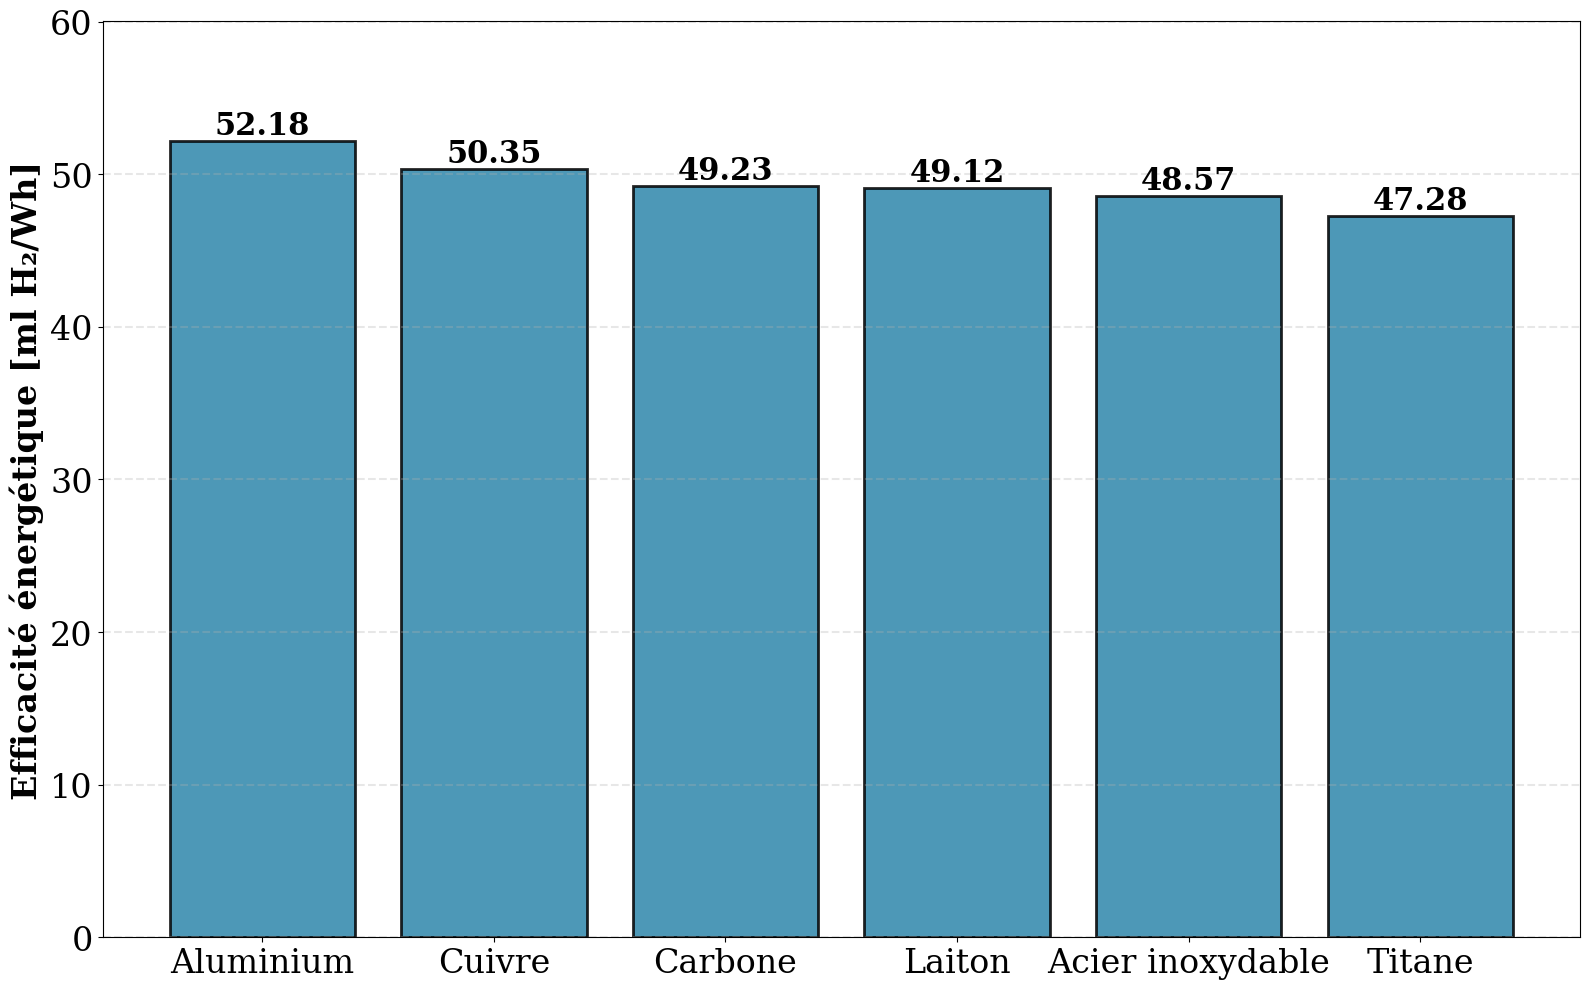


CLASSEMENT PAR EFFICACITÉ ÉNERGÉTIQUE
1. Aluminium            :   52.182 ml H₂/Wh
2. Cuivre               :   50.350 ml H₂/Wh
3. Carbone              :   49.231 ml H₂/Wh
4. Laiton               :   49.116 ml H₂/Wh
5. Acier inoxydable     :   48.571 ml H₂/Wh
6. Titane               :   47.281 ml H₂/Wh


In [143]:
# Graphique de l'efficacité énergétique
fig, ax = plt.subplots(figsize=(16, 10))

# Trier les données par efficacité pour un meilleur visuel
df_sorted = df_analyse1.sort_values('Efficacité [ml H₂/Wh]', ascending=False)

# Créer le graphique à barres
x = np.arange(len(df_sorted))
bars = ax.bar(x, df_sorted['Efficacité [ml H₂/Wh]'], 
              color='#2E86AB',
              edgecolor='black', linewidth=2, alpha=0.85)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=22, fontweight='bold')

# Configuration du graphique
#ax.set_xlabel('Type d\'électrode à la cathode', fontweight='bold')
ax.set_ylabel('Efficacité énergétique [ml H₂/Wh]', fontweight='bold')
#ax.set_title('Efficacité énergétique de production d\'hydrogène\npar type d\'électrode', fontsize=28, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(df_sorted['Électrodes'], rotation=0, ha='center')
ax.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=1.5)
ax.set_ylim(0, max(df_sorted['Efficacité [ml H₂/Wh]']) * 1.15)

plt.tight_layout()
plt.show()

# Afficher le classement
print("\n" + "="*80)
print("CLASSEMENT PAR EFFICACITÉ ÉNERGÉTIQUE")
print("="*80)
for i, (idx, row) in enumerate(df_sorted.iterrows(), 1):
    print(f"{i}. {row['Électrodes']:<20} : {row['Efficacité [ml H₂/Wh]']:>8.3f} ml H₂/Wh")
print("="*80)

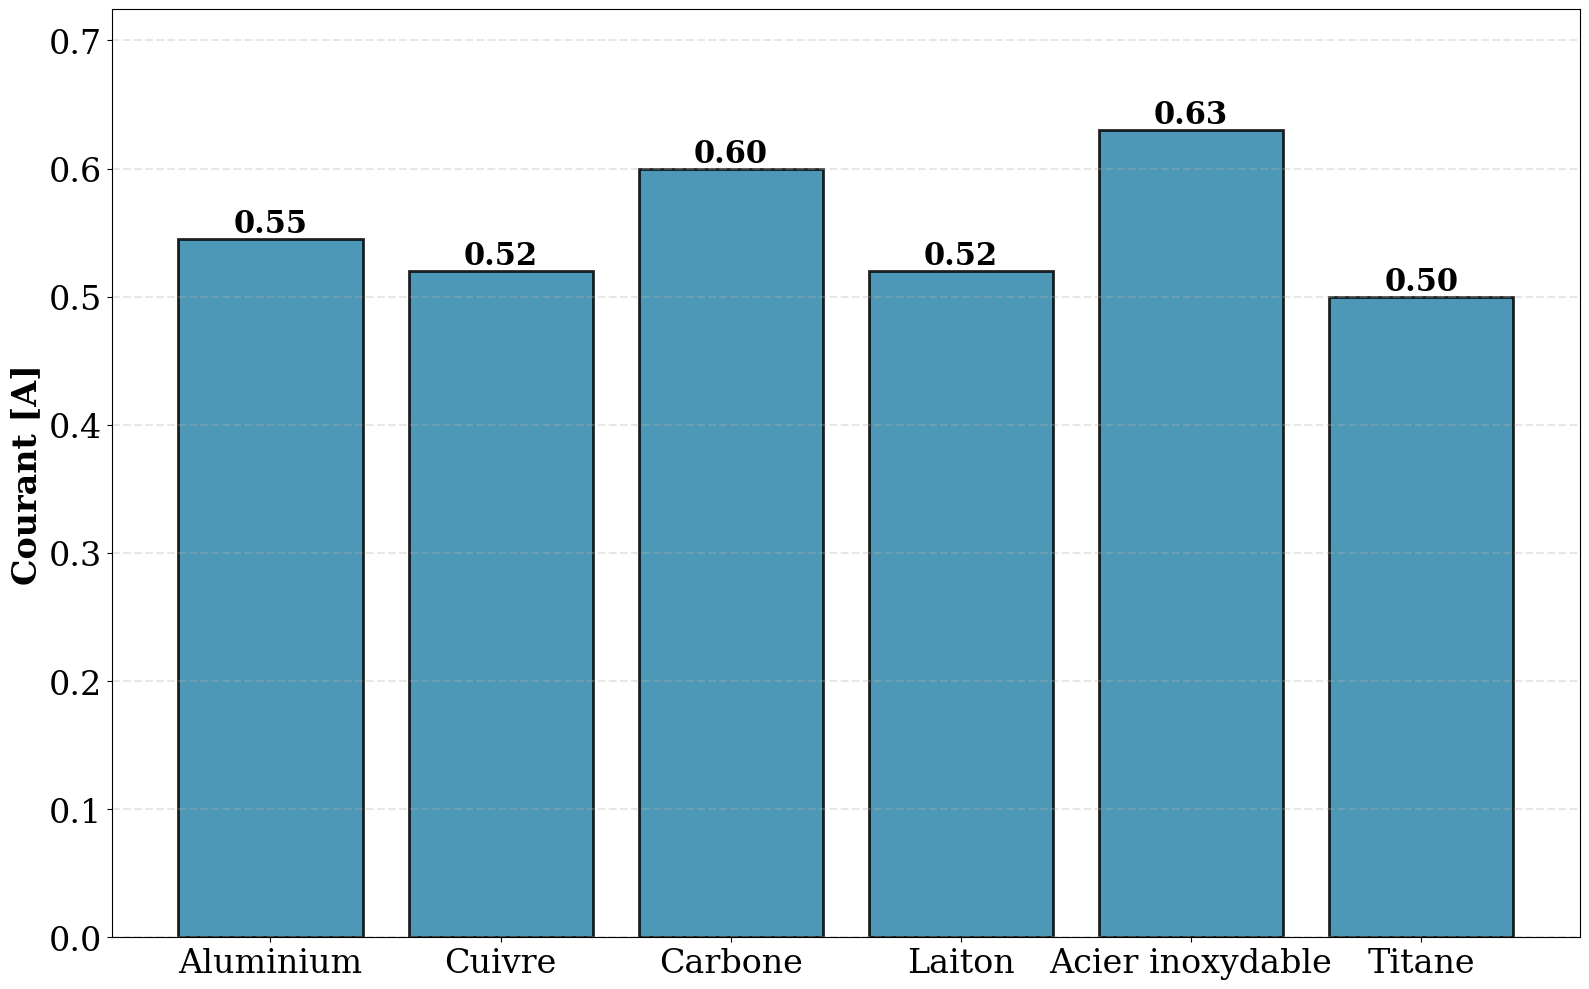

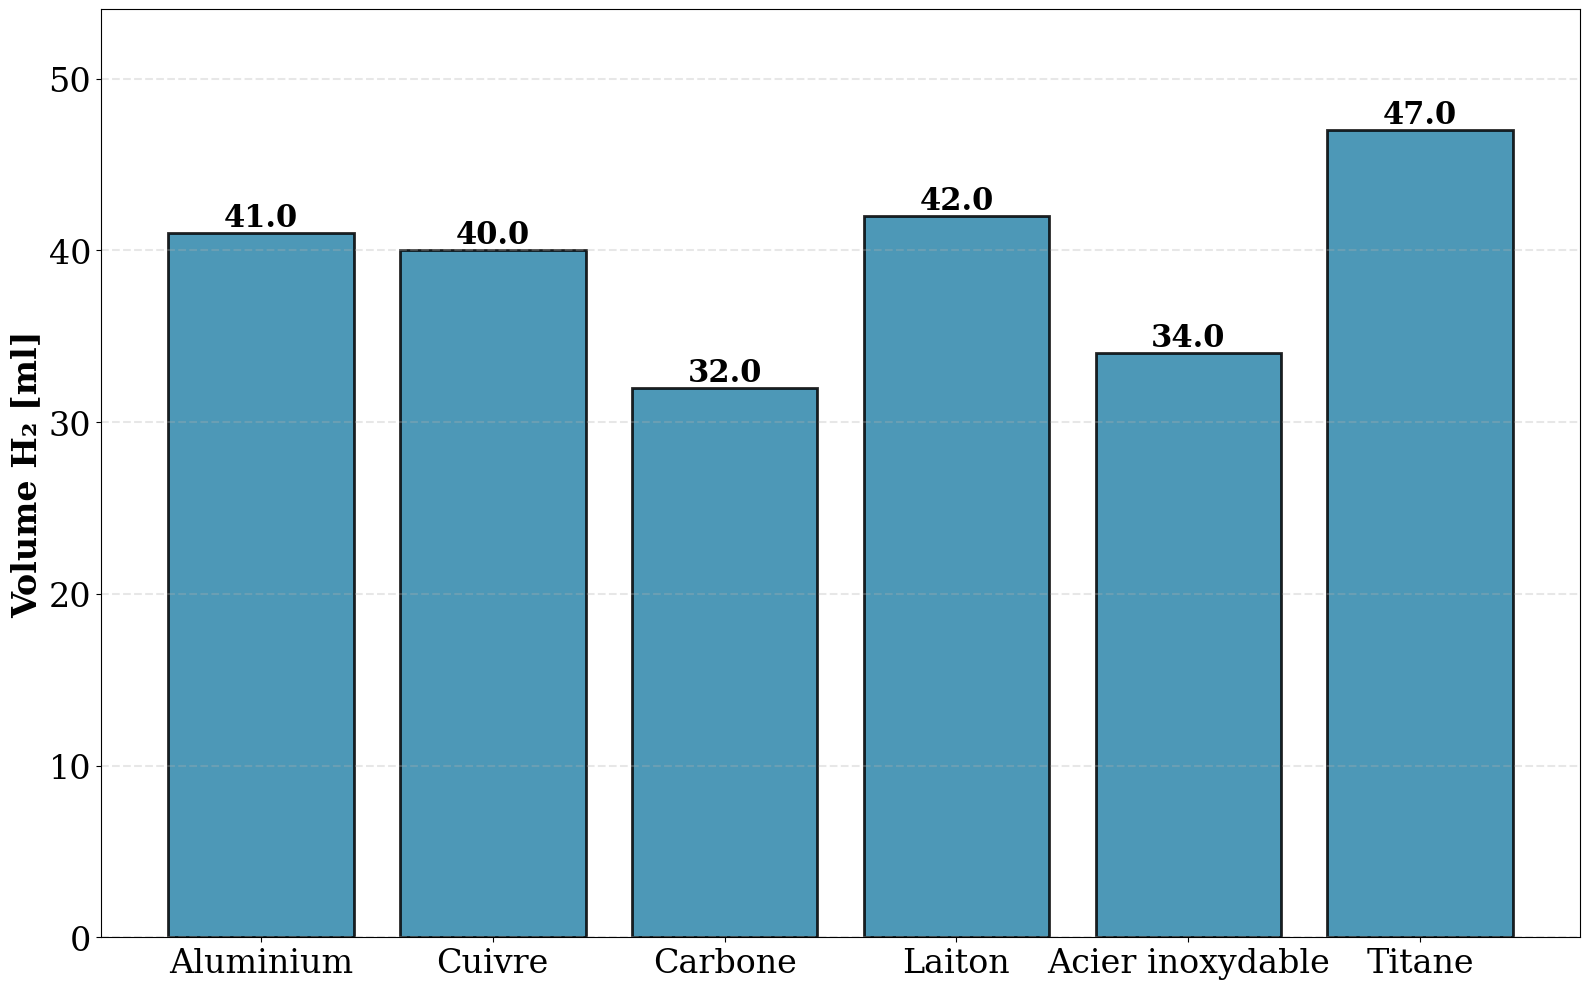

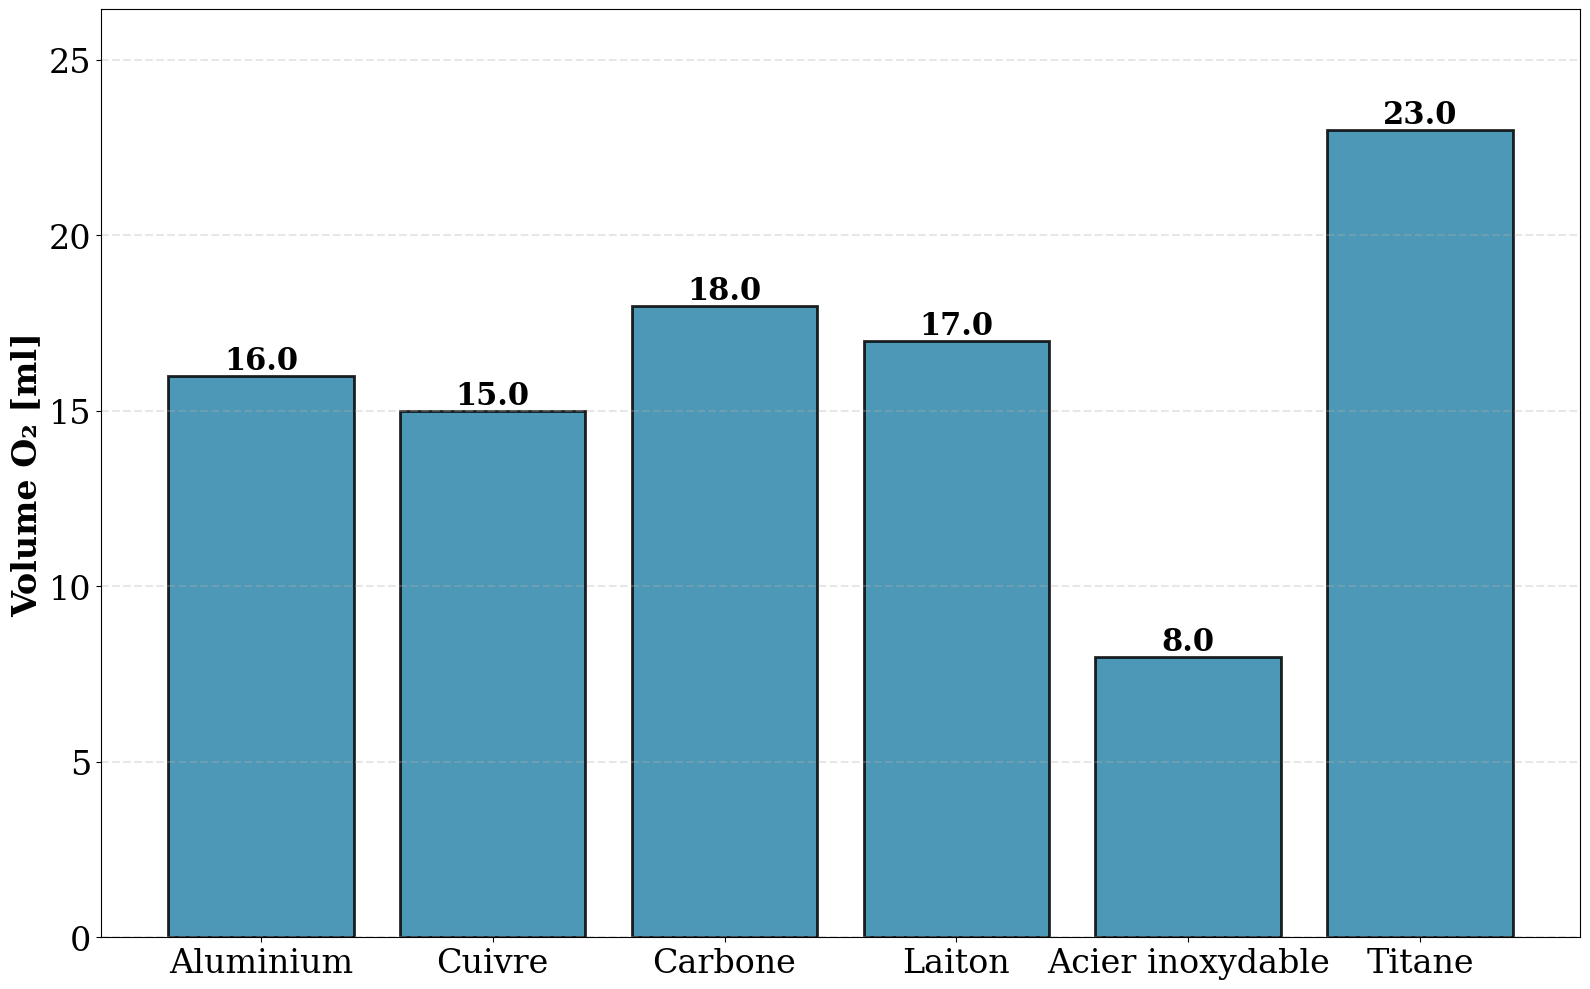

In [144]:
# Utiliser le même ordre que le graphique d'efficacité
x = np.arange(len(df_sorted))
electrodes_order = df_sorted['Électrodes'].values

# ==================== GRAPHIQUE 1: COURANT ====================
fig1, ax1 = plt.subplots(figsize=(16, 10))

bars1 = ax1.bar(x, df_sorted['Courant [A]'], 
                color='#2E86AB', edgecolor='black', linewidth=2, alpha=0.85)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=22, fontweight='bold')

#
#ax1.set_xlabel('Type d\'électrode à la cathode', fontweight='bold')
ax1.set_ylabel('Courant [A]', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(electrodes_order, rotation=0, ha='center')
ax1.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=1.5)
ax1.set_ylim(0, max(df_sorted['Courant [A]']) * 1.15)

plt.tight_layout()
plt.show()

# ==================== GRAPHIQUE 2: VOLUME H₂ ====================
fig2, ax2 = plt.subplots(figsize=(16, 10))

bars2 = ax2.bar(x, df_sorted['Volume H₂ [ml]'], 
                color='#2E86AB', edgecolor='black', linewidth=2, alpha=0.85)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom', fontsize=22, fontweight='bold')

#ax2.set_xlabel('Type d\'électrode à la cathode', fontweight='bold')
ax2.set_ylabel('Volume H₂ [ml]', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(electrodes_order, rotation=0, ha='center')
ax2.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=1.5)
ax2.set_ylim(0, max(df_sorted['Volume H₂ [ml]']) * 1.15)

plt.tight_layout()
plt.show()

# ==================== GRAPHIQUE 3: VOLUME O₂ ====================
fig3, ax3 = plt.subplots(figsize=(16, 10))

bars3 = ax3.bar(x, df_sorted['Volume O₂ [ml]'], 
                color='#2E86AB', edgecolor='black', linewidth=2, alpha=0.85)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom', fontsize=22, fontweight='bold')

#ax3.set_xlabel('Type d\'électrode à la cathode', fontweight='bold')
ax3.set_ylabel('Volume O₂ [ml]', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(electrodes_order, rotation=0, ha='center')
ax3.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=1.5)
ax3.set_ylim(0, max(df_sorted['Volume O₂ [ml]']) * 1.15)

plt.tight_layout()
plt.show()

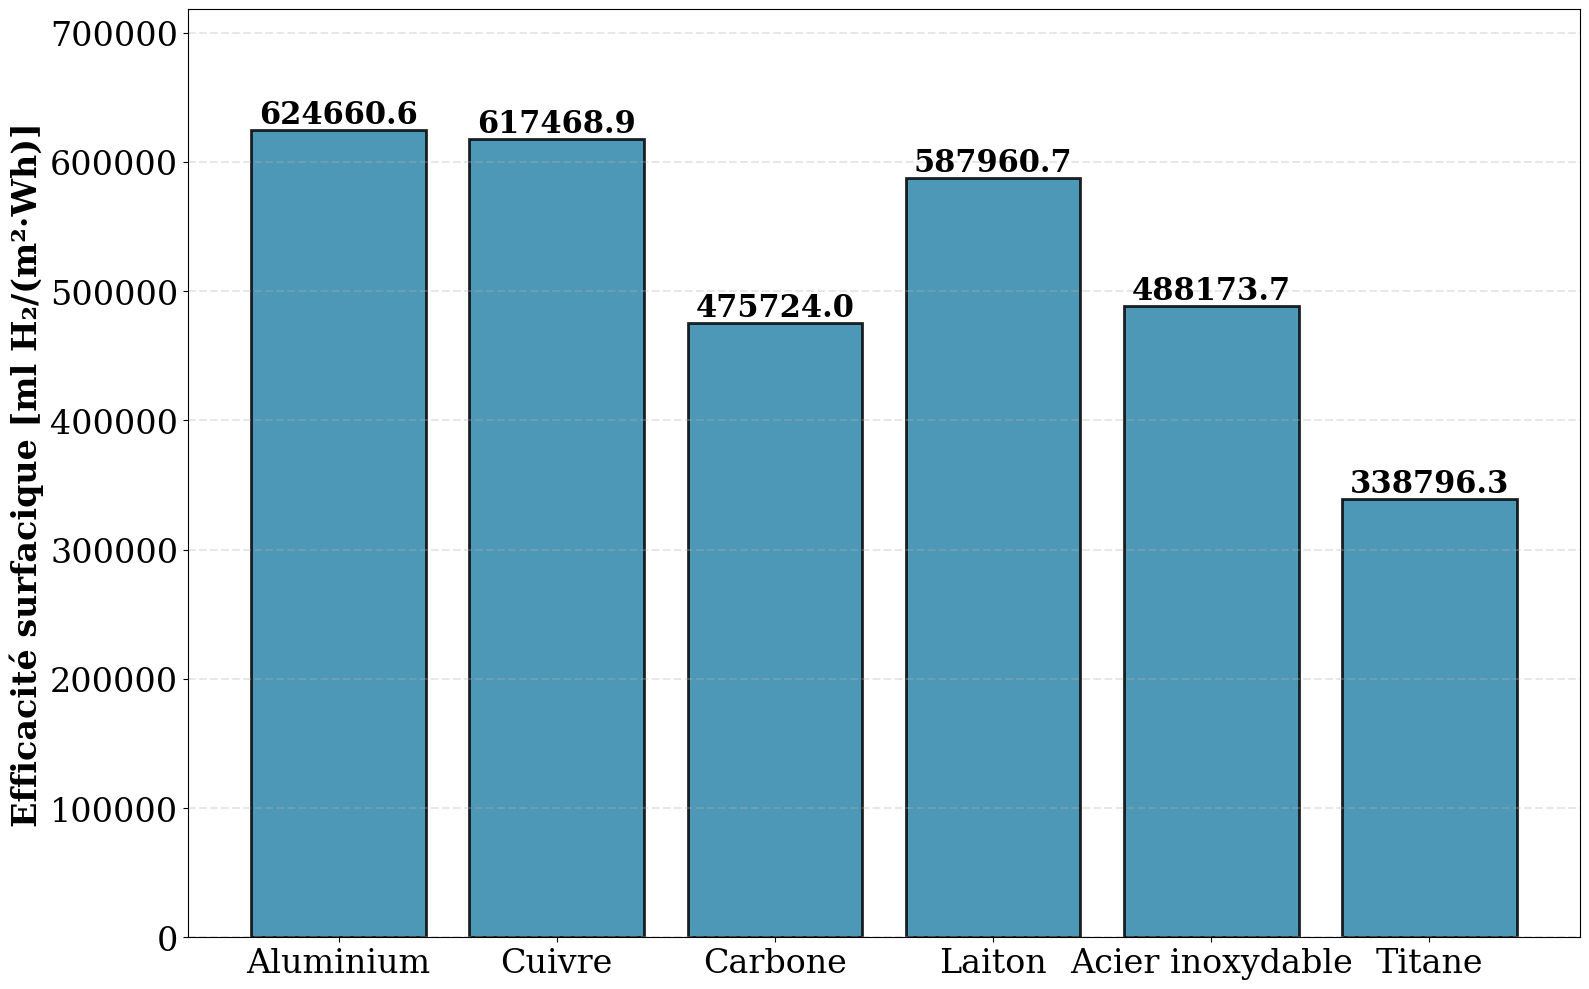


CLASSEMENT PAR EFFICACITÉ SURFACIQUE
1. Aluminium            :   624660.6 ml H₂/(m²·Wh)
2. Cuivre               :   617468.9 ml H₂/(m²·Wh)
3. Laiton               :   587960.7 ml H₂/(m²·Wh)
4. Acier inoxydable     :   488173.7 ml H₂/(m²·Wh)
5. Carbone              :   475724.0 ml H₂/(m²·Wh)
6. Titane               :   338796.3 ml H₂/(m²·Wh)


In [145]:
# ==================== GRAPHIQUE 4: EFFICACITÉ SURFACIQUE ====================
# Calculer l'efficacité surfacique (production H₂ par unité de surface de cathode)
df_sorted['Efficacité surfacique [ml H₂/(m²·Wh)]'] = (df_sorted['Volume H₂ [ml]'] / (df_sorted['Surface cathode [m²]'] * df_sorted['Énergie [J]'])) * 3600

fig4, ax4 = plt.subplots(figsize=(16, 10))

bars4 = ax4.bar(x, df_sorted['Efficacité surfacique [ml H₂/(m²·Wh)]'], 
                color='#2E86AB', edgecolor='black', linewidth=2, alpha=0.85)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom', fontsize=22, fontweight='bold')

ax4.set_ylabel('Efficacité surfacique [ml H₂/(m²·Wh)]', fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(electrodes_order, rotation=0, ha='center')
ax4.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=1.5)
ax4.set_ylim(0, max(df_sorted['Efficacité surfacique [ml H₂/(m²·Wh)]']) * 1.15)

plt.tight_layout()
plt.show()

# Afficher le classement par efficacité surfacique
df_sorted_surf = df_sorted.sort_values('Efficacité surfacique [ml H₂/(m²·Wh)]', ascending=False)
print("\n" + "="*80)
print("CLASSEMENT PAR EFFICACITÉ SURFACIQUE")
print("="*80)
for i, (idx, row) in enumerate(df_sorted_surf.iterrows(), 1):
    print(f"{i}. {row['Électrodes']:<20} : {row['Efficacité surfacique [ml H₂/(m²·Wh)]']:>10.1f} ml H₂/(m²·Wh)")
print("="*80)

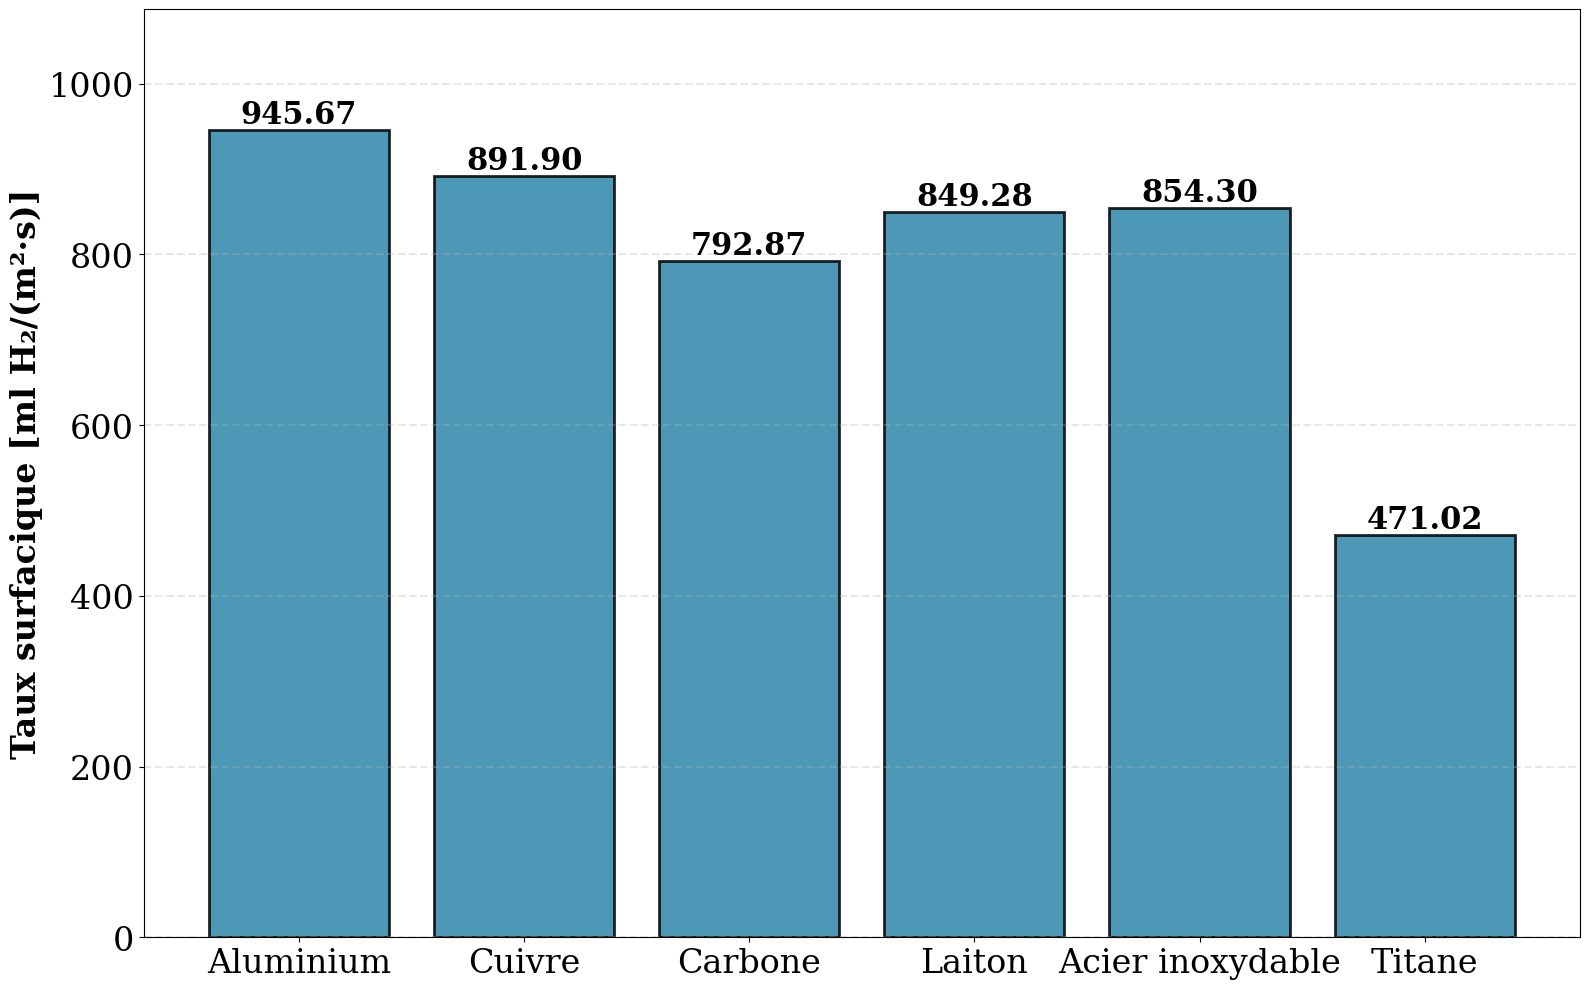


CLASSEMENT PAR TAUX SURFACIQUE
1. Aluminium            :     945.67 ml H₂/(m²·s)
2. Cuivre               :     891.90 ml H₂/(m²·s)
3. Acier inoxydable     :     854.30 ml H₂/(m²·s)
4. Laiton               :     849.28 ml H₂/(m²·s)
5. Carbone              :     792.87 ml H₂/(m²·s)
6. Titane               :     471.02 ml H₂/(m²·s)


In [146]:
# ==================== GRAPHIQUE 5: TAUX SURFACIQUE ====================
# Calculer le taux surfacique (production H₂ par unité de surface de cathode par unité de temps)
df_sorted['Taux surfacique [ml H₂/(m²·s)]'] = df_sorted['Volume H₂ [ml]'] / (df_sorted['Surface cathode [m²]'] * df_sorted['Temps [s]'])

fig5, ax5 = plt.subplots(figsize=(16, 10))

bars5 = ax5.bar(x, df_sorted['Taux surfacique [ml H₂/(m²·s)]'], 
                color='#2E86AB', edgecolor='black', linewidth=2, alpha=0.85)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars5):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=22, fontweight='bold')

ax5.set_ylabel('Taux surfacique [ml H₂/(m²·s)]', fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(electrodes_order, rotation=0, ha='center')
ax5.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=1.5)
ax5.set_ylim(0, max(df_sorted['Taux surfacique [ml H₂/(m²·s)]']) * 1.15)

plt.tight_layout()
plt.show()

# Afficher le classement par taux surfacique
df_sorted_taux = df_sorted.sort_values('Taux surfacique [ml H₂/(m²·s)]', ascending=False)
print("\n" + "="*80)
print("CLASSEMENT PAR TAUX SURFACIQUE")
print("="*80)
for i, (idx, row) in enumerate(df_sorted_taux.iterrows(), 1):
    print(f"{i}. {row['Électrodes']:<20} : {row['Taux surfacique [ml H₂/(m²·s)]']:>10.2f} ml H₂/(m²·s)")
print("="*80)

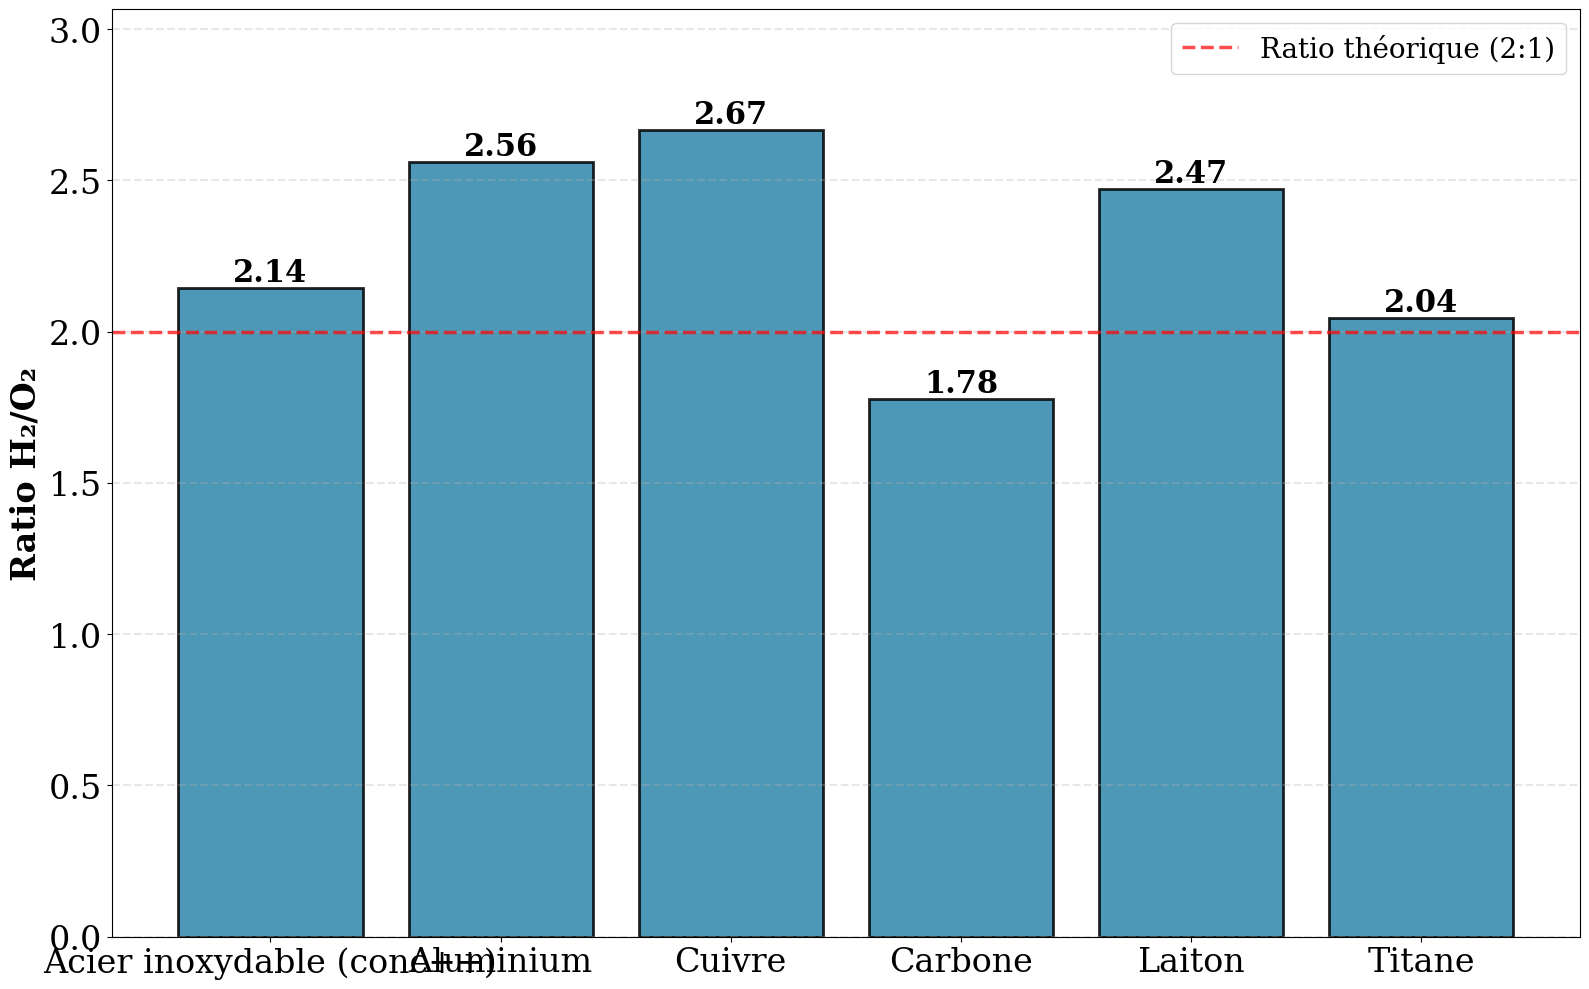


ANALYSE DU RATIO H₂/O₂
Électrode                       Ratio H₂/O₂   Écart au théorique    % Écart
--------------------------------------------------------------------------------
Acier inoxydable (conc++)              2.14                 0.14       7.1%
Aluminium                              2.56                 0.56      28.1%
Cuivre                                 2.67                 0.67      33.3%
Carbone                                1.78                -0.22     -11.1%
Laiton                                 2.47                 0.47      23.5%
Titane                                 2.04                 0.04       2.2%

Ratio théorique (électrolyse de l'eau): 2.0
Ratio moyen observé: 2.28
Écart-type: 0.34


In [147]:
# ==================== GRAPHIQUE 6: RATIO H₂/O₂ ====================
# Analyser le ratio H₂/O₂ pour chaque électrode
# Utiliser l'acier inoxydable (conc++) au lieu de l'acier inoxydable normal

# Créer un DataFrame modifié pour ce graphique
df_sorted_ratio = df_sorted.copy()

# Remplacer la ligne 'Acier inoxydable' par 'Acier inoxydable (conc++)'
df_sorted_ratio = df_sorted_ratio[df_sorted_ratio['Électrodes'] != 'Acier inoxydable'].copy()

# Ajouter l'acier inoxydable (conc++) depuis df_analyse2
acier_conc = df_analyse2[df_analyse2['Électrodes'] == 'Acier inoxydable (conc++)'].copy()
df_sorted_ratio = pd.concat([df_sorted_ratio, acier_conc], ignore_index=True)

# Retrier par efficacité pour maintenir l'ordre
df_sorted_ratio = df_sorted_ratio.sort_values('Efficacité [ml H₂/Wh]', ascending=False)

# Recréer les positions x
x_ratio = np.arange(len(df_sorted_ratio))
electrodes_order_ratio = df_sorted_ratio['Électrodes'].values

fig6, ax6 = plt.subplots(figsize=(16, 10))

bars6 = ax6.bar(x_ratio, df_sorted_ratio['Ratio H₂/O₂'], 
                color='#2E86AB', edgecolor='black', linewidth=2, alpha=0.85)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars6):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=22, fontweight='bold')

# Ajouter une ligne horizontale pour le ratio théorique (2:1)
ax6.axhline(y=2.0, color='red', linestyle='--', linewidth=2.5, 
            label='Ratio théorique (2:1)', alpha=0.7)

ax6.set_ylabel('Ratio H₂/O₂', fontweight='bold')
ax6.set_xticks(x_ratio)
ax6.set_xticklabels(electrodes_order_ratio, rotation=0, ha='center')
ax6.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=1.5)
ax6.set_ylim(0, max(df_sorted_ratio['Ratio H₂/O₂']) * 1.15)
ax6.legend(loc='upper right', fontsize=20)

plt.tight_layout()
plt.show()

# Afficher l'analyse du ratio
print("\n" + "="*80)
print("ANALYSE DU RATIO H₂/O₂")
print("="*80)
print(f"{'Électrode':<30} {'Ratio H₂/O₂':>12} {'Écart au théorique':>20} {'% Écart':>10}")
print("-"*80)

for idx, row in df_sorted_ratio.iterrows():
    ratio = row['Ratio H₂/O₂']
    ecart = ratio - 2.0
    ecart_pct = (ecart / 2.0) * 100
    print(f"{row['Électrodes']:<30} {ratio:>12.2f} {ecart:>20.2f} {ecart_pct:>9.1f}%")

print("="*80)
print(f"\nRatio théorique (électrolyse de l'eau): 2.0")
print(f"Ratio moyen observé: {df_sorted_ratio['Ratio H₂/O₂'].mean():.2f}")
print(f"Écart-type: {df_sorted_ratio['Ratio H₂/O₂'].std():.2f}")
print("="*80)

## Analyse 2 : Effet de la concentration d'électrolyte

Comparaison de l'effet de la concentration de NaHCO₃ sur les performances d'électrolyse.

In [ ]:
# Créer un DataFrame pour l'analyse 2 : comparaison des concentrations
# Inclure toutes les électrodes de l'analyse 1 + Stainless (concentration++)

electrodes_analyse2 = electrodes_analyse1 + ['Stainless (concentration++)']

df_analyse2 = df[df['Électrodes'].isin(electrodes_analyse2)].copy()

# Renommer les électrodes
df_analyse2['Électrodes'] = df_analyse2['Électrodes'].replace({
    'Cuivre- Carbon+ V2': 'Cuivre',
    'Stainless': 'Acier inoxydable',
    'Titane- carbone+': 'Titane',
    'Stainless (concentration++)': 'Acier inoxydable (conc++)'
})

# Calculer les métriques dérivées pour l'Analyse 2
df_analyse2['Efficacité surfacique [ml H₂/(m²·Wh)]'] = (df_analyse2['Volume H₂ [ml]'] / (df_analyse2['Surface cathode [m²]'] * df_analyse2['Énergie [J]'])) * 3600
df_analyse2['Taux surfacique [ml H₂/(m²·s)]'] = df_analyse2['Volume H₂ [ml]'] / (df_analyse2['Surface cathode [m²]'] * df_analyse2['Temps [s]'])

print("="*120)
print("ANALYSE 2 - EFFET DE LA CONCENTRATION D'ÉLECTROLYTE")
print("="*120)
print(df_analyse2.to_string(index=False))
print("\n" + "="*120)
print(f"Nombre de configurations: {len(df_analyse2)}")
print("="*120)

# Statistiques par concentration
print("\n" + "="*120)
print("COMPARAISON PAR CONCENTRATION")
print("="*120)
conc_normale = df_analyse2[df_analyse2['Concentration NaHCO₃ [g/g]'] < 0.03]
conc_elevee = df_analyse2[df_analyse2['Concentration NaHCO₃ [g/g]'] > 0.03]

print(f"\nConcentration normale (1.81e-2 g/g):")
print(f"  Efficacité moyenne: {conc_normale['Efficacité [ml H₂/Wh]'].mean():.2f} ml H₂/Wh")
print(f"  Courant moyen: {conc_normale['Courant [A]'].mean():.3f} A")
print(f"  Volume H₂ moyen: {conc_normale['Volume H₂ [ml]'].mean():.2f} ml")

print(f"\nConcentration élevée (4.49e-2 g/g):")
print(f"  Efficacité: {conc_elevee['Efficacité [ml H₂/Wh]'].iloc[0]:.2f} ml H₂/Wh")
print(f"  Courant: {conc_elevee['Courant [A]'].iloc[0]:.3f} A")
print(f"  Volume H₂: {conc_elevee['Volume H₂ [ml]'].iloc[0]:.2f} ml")
print("="*120)

ANALYSE 2 - EFFET DE LA CONCENTRATION D'ÉLECTROLYTE
               Électrodes  Concentration NaHCO₃ [g/g]  Courant [A]  Tension [V]  Temps [s]  Volume H₂ [ml]  Volume O₂ [ml]  Surface anode [m²]  Surface cathode [m²]  Puissance [W]  Énergie [J]  Taux H₂ [ml/s]  Taux O₂ [ml/s]  Ratio H₂/O₂  Efficacité [ml H₂/Wh]  Résistance [Ω]  Efficacité surfacique [ml H₂/(m²·Wh)]  Taux surfacique [ml H₂/(m²·s)]
                   Laiton                    0.018100        0.520        10.00        592            42.0            17.0            0.000153              0.000084          5.200     3078.400        0.070946        0.028716     2.470588              49.116424       19.230769                          587960.748326                      849.276636
                   Cuivre                    0.018100        0.520        10.00        550            40.0            15.0            0.000153              0.000082          5.200     2860.000        0.072727        0.027273     2.666667              5

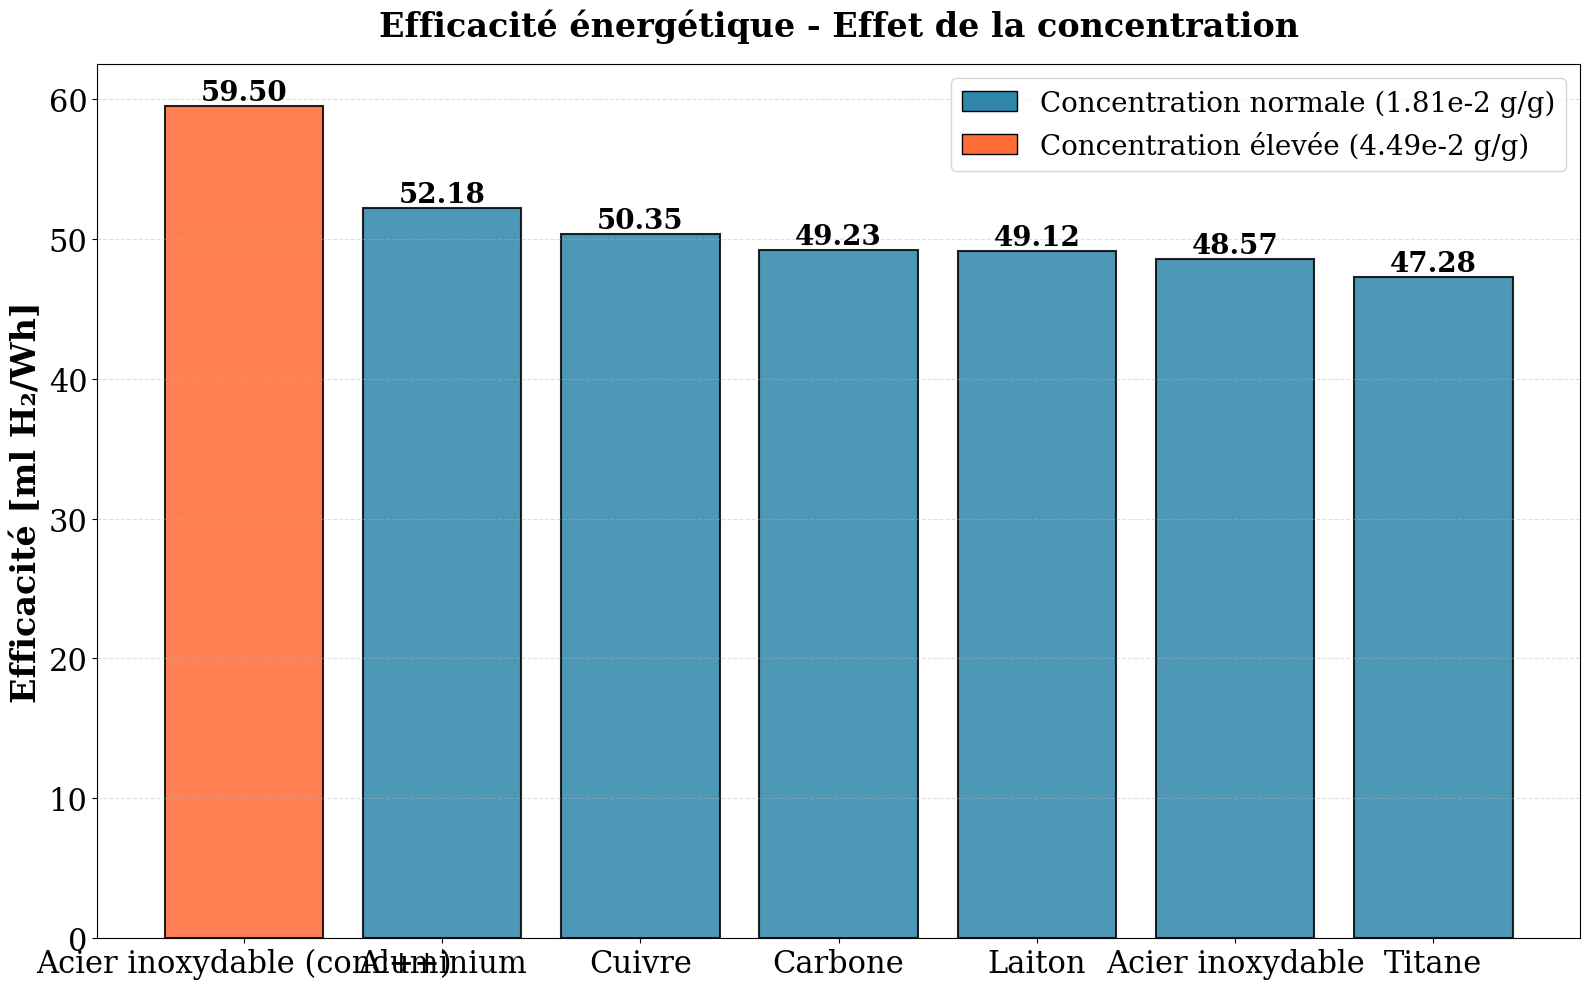


Classification par efficacité (Analyse 2):
  Acier inoxydable (conc++)      :  59.50 ml H₂/Wh (concentration élevée)
  Aluminium                      :  52.18 ml H₂/Wh (concentration normale)
  Cuivre                         :  50.35 ml H₂/Wh (concentration normale)
  Carbone                        :  49.23 ml H₂/Wh (concentration normale)
  Laiton                         :  49.12 ml H₂/Wh (concentration normale)
  Acier inoxydable               :  48.57 ml H₂/Wh (concentration normale)
  Titane                         :  47.28 ml H₂/Wh (concentration normale)


In [ ]:
# Graphique 1: Comparaison de l'efficacité énergétique avec concentration élevée

# Trier par efficacité
df_analyse2_sorted = df_analyse2.sort_values('Efficacité [ml H₂/Wh]', ascending=False)

fig_a2_1, ax = plt.subplots(figsize=(16, 10))

# Créer les barres avec des couleurs différentes pour les concentrations
colors = ['#2E86AB' if conc < 0.03 else '#FF6B35' 
          for conc in df_analyse2_sorted['Concentration NaHCO₃ [g/g]']]

bars = ax.bar(df_analyse2_sorted['Électrodes'], 
              df_analyse2_sorted['Efficacité [ml H₂/Wh]'],
              color=colors, alpha=0.85, edgecolor='black', linewidth=1.5)

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=20, fontweight='bold')

ax.set_ylabel('Efficacité [ml H₂/Wh]', fontsize=24, fontweight='bold')
ax.set_title('Efficacité énergétique - Effet de la concentration', 
             fontsize=24, fontweight='bold', pad=20)
ax.tick_params(axis='both', labelsize=22)
ax.tick_params(axis='x', rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Légende pour les concentrations
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2E86AB', edgecolor='black', label='Concentration normale (1.81e-2 g/g)'),
                   Patch(facecolor='#FF6B35', edgecolor='black', label='Concentration élevée (4.49e-2 g/g)')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=20)

plt.tight_layout()
plt.show()

print("\nClassification par efficacité (Analyse 2):")
for idx, row in df_analyse2_sorted.iterrows():
    conc_label = "élevée" if row['Concentration NaHCO₃ [g/g]'] > 0.03 else "normale"
    print(f"  {row['Électrodes']:30s} : {row['Efficacité [ml H₂/Wh]']:6.2f} ml H₂/Wh (concentration {conc_label})")

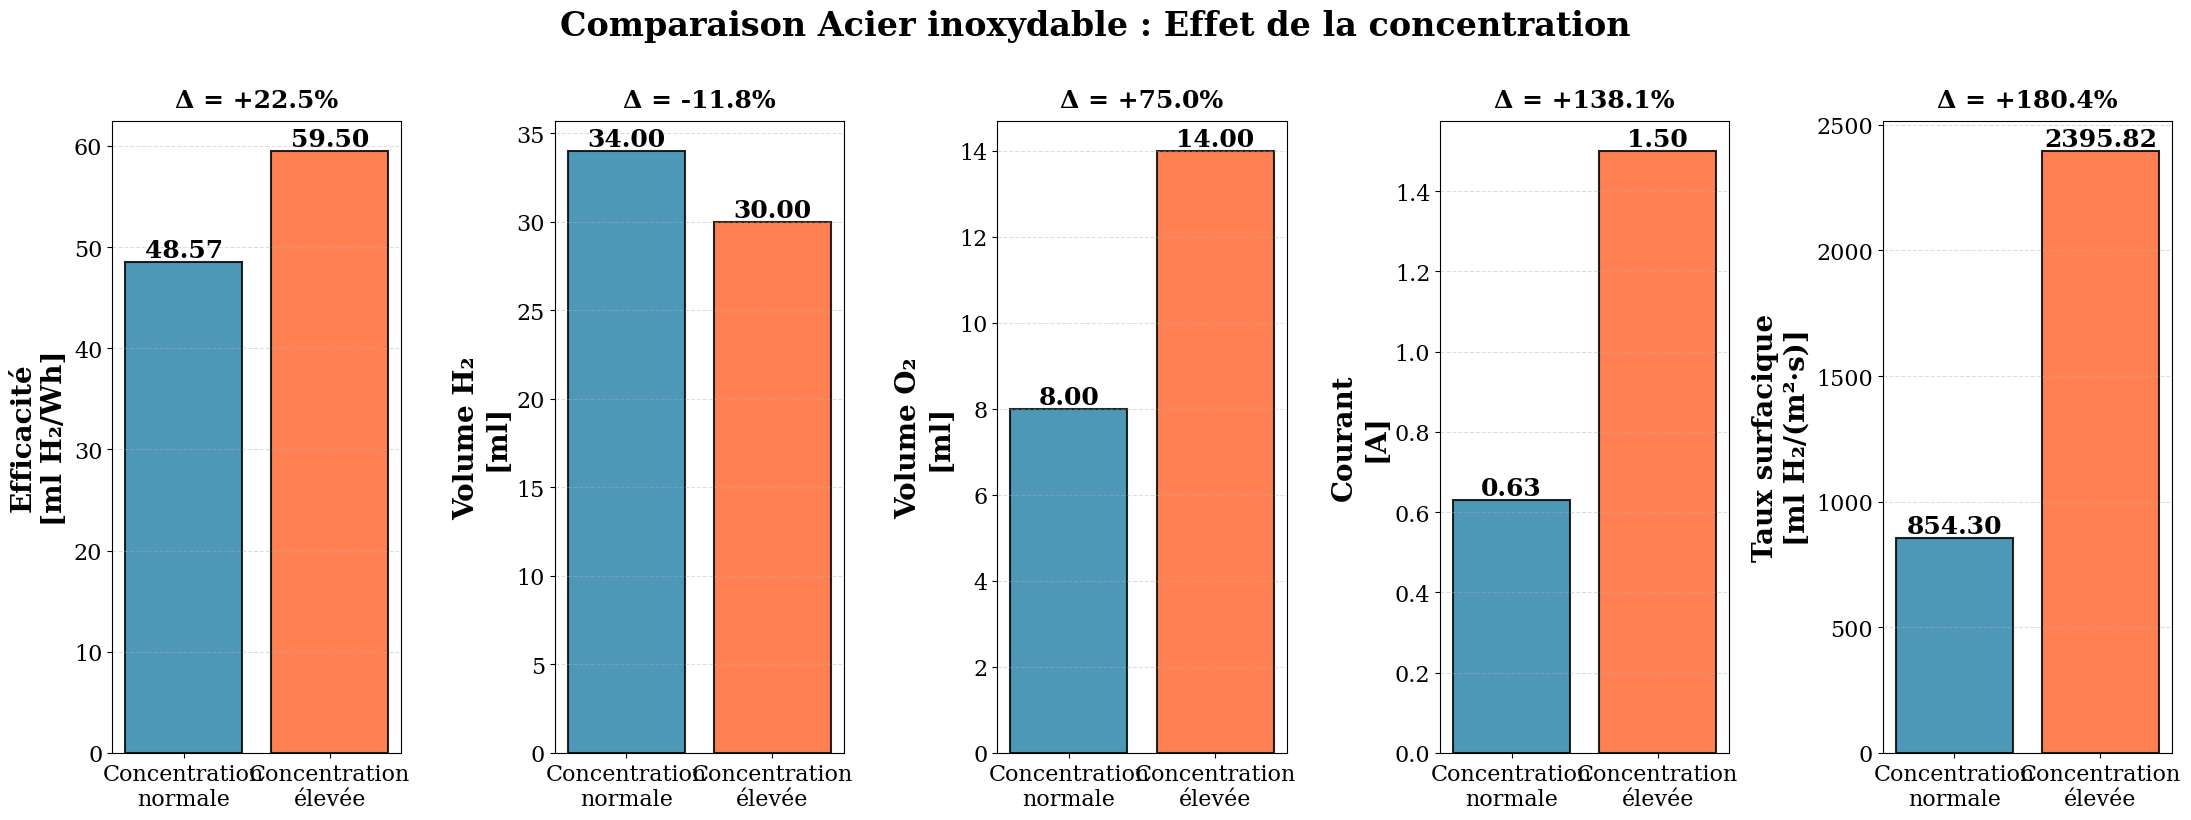


COMPARAISON ACIER INOXYDABLE - EFFET DE LA CONCENTRATION
Métrique                                 |   Conc. normale |    Conc. élevée |    Variation
------------------------------------------------------------------------------------------------------------------------
Efficacité [ml H₂/Wh]                    |         48.5714 |         59.5041 |      +22.51%
Volume H₂ [ml]                           |         34.0000 |         30.0000 |      -11.76%
Volume O₂ [ml]                           |          8.0000 |         14.0000 |      +75.00%
Courant [A]                              |          0.6300 |          1.5000 |     +138.10%
Taux surfacique [ml H₂/(m²·s)]           |        854.3040 |       2395.8205 |     +180.44%


In [ ]:
# Graphique 2: Comparaison directe Acier inoxydable vs Acier inoxydable (conc++)

# Extraire les données des deux configurations d'acier
df_acier_normal = df_analyse2[df_analyse2['Électrodes'] == 'Acier inoxydable']
df_acier_conc = df_analyse2[df_analyse2['Électrodes'] == 'Acier inoxydable (conc++)']

# Créer un tableau comparatif
metriques = ['Efficacité [ml H₂/Wh]', 'Volume H₂ [ml]', 'Volume O₂ [ml]', 
             'Courant [A]', 'Taux surfacique [ml H₂/(m²·s)]']
etiquettes = ['Efficacité\n[ml H₂/Wh]', 'Volume H₂\n[ml]', 'Volume O₂\n[ml]', 
              'Courant\n[A]', 'Taux surfacique\n[ml H₂/(m²·s)]']

fig_a2_2, axes = plt.subplots(1, 5, figsize=(22, 8))

for idx, (metrique, etiquette) in enumerate(zip(metriques, etiquettes)):
    ax = axes[idx]
    
    valeur_normale = df_acier_normal[metrique].iloc[0]
    valeur_conc = df_acier_conc[metrique].iloc[0]
    
    bars = ax.bar(['Concentration\nnormale', 'Concentration\nélevée'], 
                   [valeur_normale, valeur_conc],
                   color=['#2E86AB', '#FF6B35'], alpha=0.85, 
                   edgecolor='black', linewidth=1.5)
    
    # Ajouter les valeurs
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=18, fontweight='bold')
    
    ax.set_ylabel(etiquette, fontsize=20, fontweight='bold')
    ax.tick_params(axis='both', labelsize=16)
    ax.tick_params(axis='x', rotation=0)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    
    # Calculer et afficher le pourcentage d'augmentation
    augmentation = ((valeur_conc - valeur_normale) / valeur_normale) * 100
    ax.set_title(f'Δ = {augmentation:+.1f}%', fontsize=18, fontweight='bold', pad=10)

fig_a2_2.suptitle('Comparaison Acier inoxydable : Effet de la concentration', 
                   fontsize=24, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tableau récapitulatif
print("\n" + "="*120)
print("COMPARAISON ACIER INOXYDABLE - EFFET DE LA CONCENTRATION")
print("="*120)
print(f"{'Métrique':40s} | {'Conc. normale':>15s} | {'Conc. élevée':>15s} | {'Variation':>12s}")
print("-"*120)
for metrique in metriques:
    val_normale = df_acier_normal[metrique].iloc[0]
    val_conc = df_acier_conc[metrique].iloc[0]
    variation = ((val_conc - val_normale) / val_normale) * 100
    print(f"{metrique:40s} | {val_normale:15.4f} | {val_conc:15.4f} | {variation:+11.2f}%")
print("="*120)

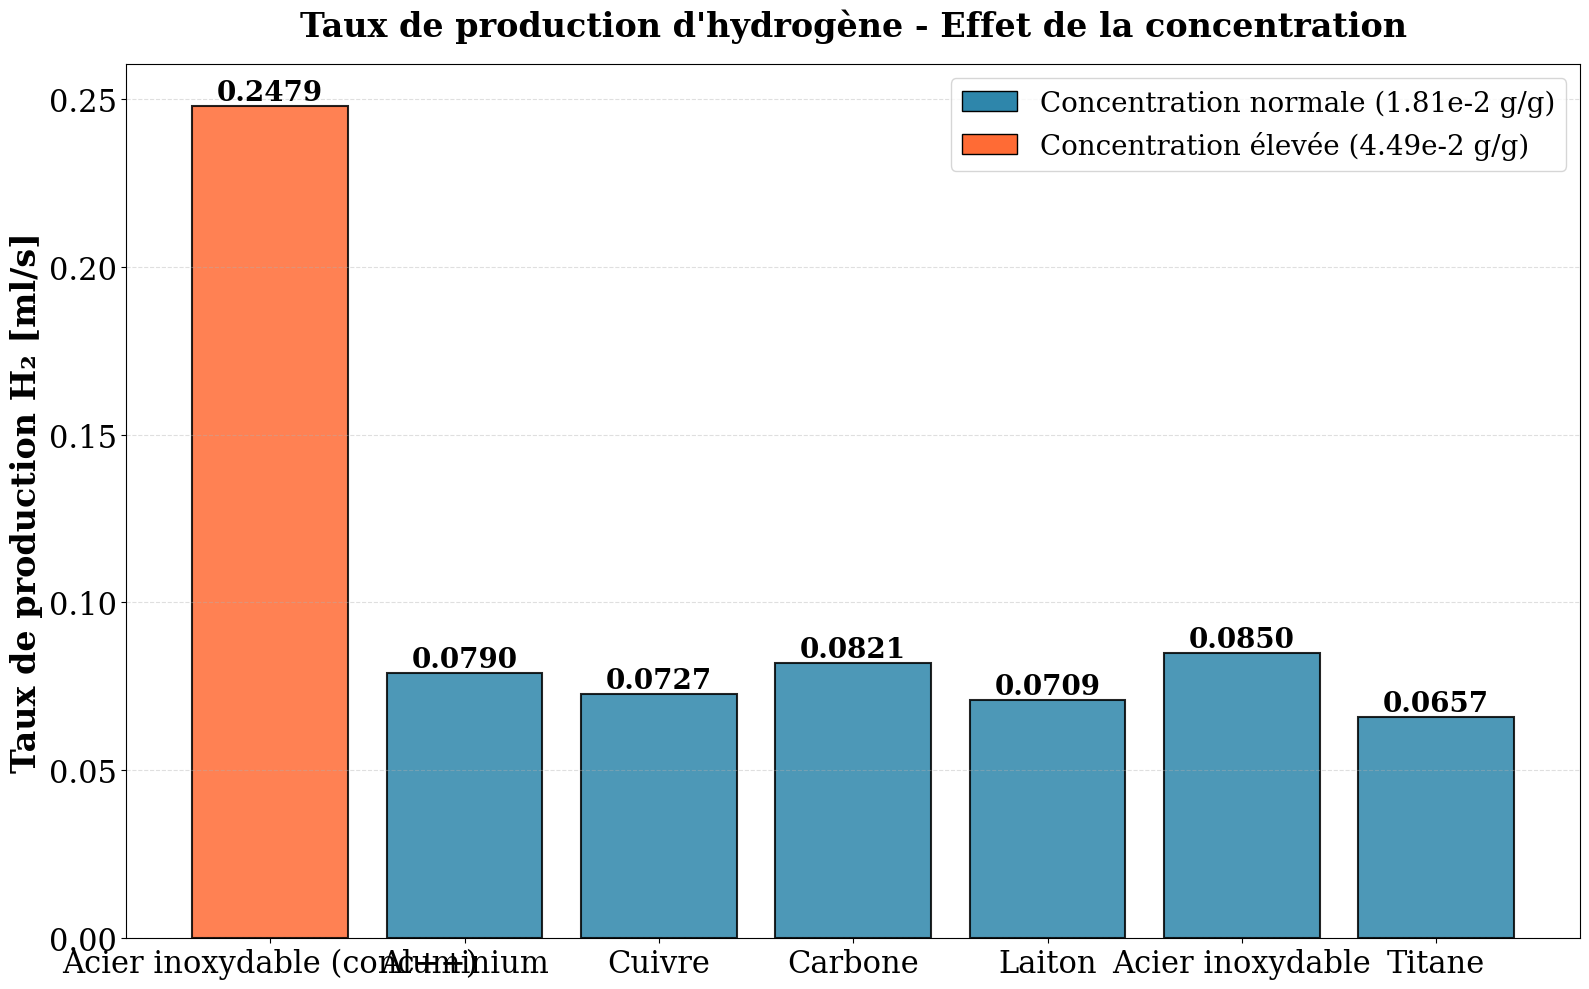


Classification par taux de production H₂ (Analyse 2):
  Acier inoxydable (conc++)      : 0.2479 ml/s (concentration élevée)
  Aluminium                      : 0.0790 ml/s (concentration normale)
  Cuivre                         : 0.0727 ml/s (concentration normale)
  Carbone                        : 0.0821 ml/s (concentration normale)
  Laiton                         : 0.0709 ml/s (concentration normale)
  Acier inoxydable               : 0.0850 ml/s (concentration normale)
  Titane                         : 0.0657 ml/s (concentration normale)


In [ ]:
# Graphique 3: Effet de la concentration sur le taux de production d'H₂

fig_a2_3, ax = plt.subplots(figsize=(16, 10))

# Utiliser l'ordre de l'analyse 2
colors = ['#2E86AB' if conc < 0.03 else '#FF6B35' 
          for conc in df_analyse2_sorted['Concentration NaHCO₃ [g/g]']]

bars = ax.bar(df_analyse2_sorted['Électrodes'], 
              df_analyse2_sorted['Taux H₂ [ml/s]'],
              color=colors, alpha=0.85, edgecolor='black', linewidth=1.5)

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=20, fontweight='bold')

ax.set_ylabel('Taux de production H₂ [ml/s]', fontsize=24, fontweight='bold')
ax.set_title('Taux de production d\'hydrogène - Effet de la concentration', 
             fontsize=24, fontweight='bold', pad=20)
ax.tick_params(axis='both', labelsize=22)
ax.tick_params(axis='x', rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Légende
ax.legend(handles=legend_elements, loc='upper right', fontsize=20)

plt.tight_layout()
plt.show()

print("\nClassification par taux de production H₂ (Analyse 2):")
for idx, row in df_analyse2_sorted.iterrows():
    conc_label = "élevée" if row['Concentration NaHCO₃ [g/g]'] > 0.03 else "normale"
    print(f"  {row['Électrodes']:30s} : {row['Taux H₂ [ml/s]']:.4f} ml/s (concentration {conc_label})")

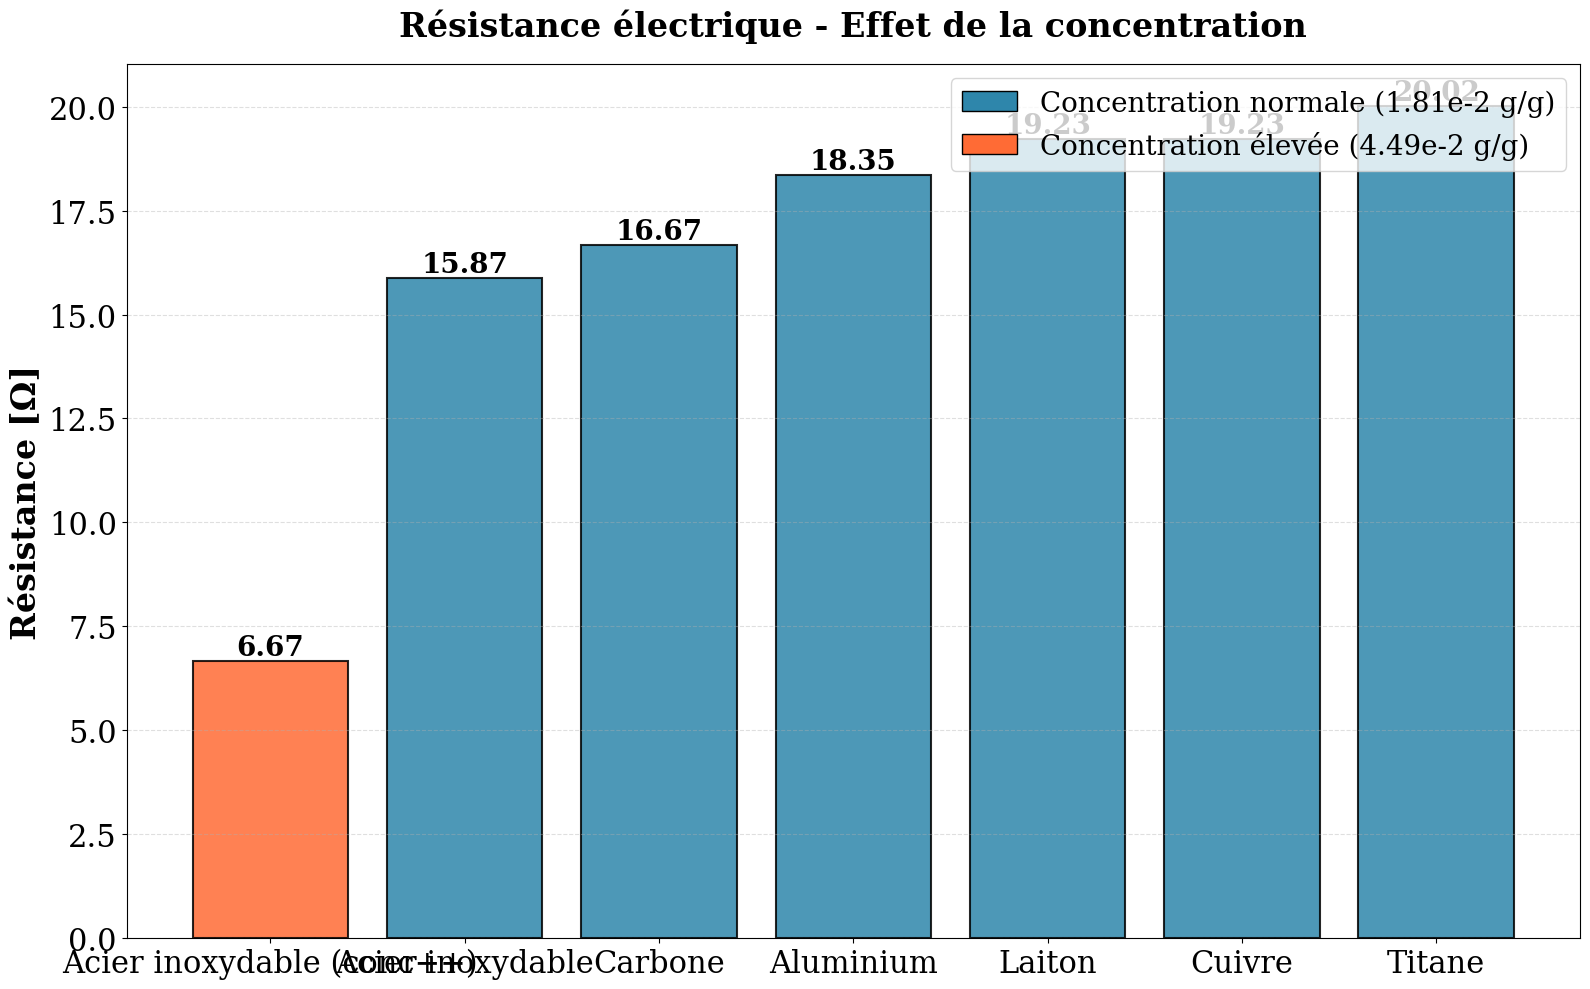


Classification par résistance (Analyse 2):
  Acier inoxydable (conc++)      :   6.67 Ω (concentration élevée)
  Acier inoxydable               :  15.87 Ω (concentration normale)
  Carbone                        :  16.67 Ω (concentration normale)
  Aluminium                      :  18.35 Ω (concentration normale)
  Laiton                         :  19.23 Ω (concentration normale)
  Cuivre                         :  19.23 Ω (concentration normale)
  Titane                         :  20.02 Ω (concentration normale)


In [ ]:
# Graphique 4: Effet de la concentration sur la résistance

fig_a2_4, ax = plt.subplots(figsize=(16, 10))

# Trier par résistance
df_analyse2_res = df_analyse2.sort_values('Résistance [Ω]', ascending=True)

colors_res = ['#2E86AB' if conc < 0.03 else '#FF6B35' 
              for conc in df_analyse2_res['Concentration NaHCO₃ [g/g]']]

bars = ax.bar(df_analyse2_res['Électrodes'], 
              df_analyse2_res['Résistance [Ω]'],
              color=colors_res, alpha=0.85, edgecolor='black', linewidth=1.5)

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=20, fontweight='bold')

ax.set_ylabel('Résistance [Ω]', fontsize=24, fontweight='bold')
ax.set_title('Résistance électrique - Effet de la concentration', 
             fontsize=24, fontweight='bold', pad=20)
ax.tick_params(axis='both', labelsize=22)
ax.tick_params(axis='x', rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Légende
ax.legend(handles=legend_elements, loc='upper right', fontsize=20)

plt.tight_layout()
plt.show()

print("\nClassification par résistance (Analyse 2):")
for idx, row in df_analyse2_res.iterrows():
    conc_label = "élevée" if row['Concentration NaHCO₃ [g/g]'] > 0.03 else "normale"
    print(f"  {row['Électrodes']:30s} : {row['Résistance [Ω]']:6.2f} Ω (concentration {conc_label})")

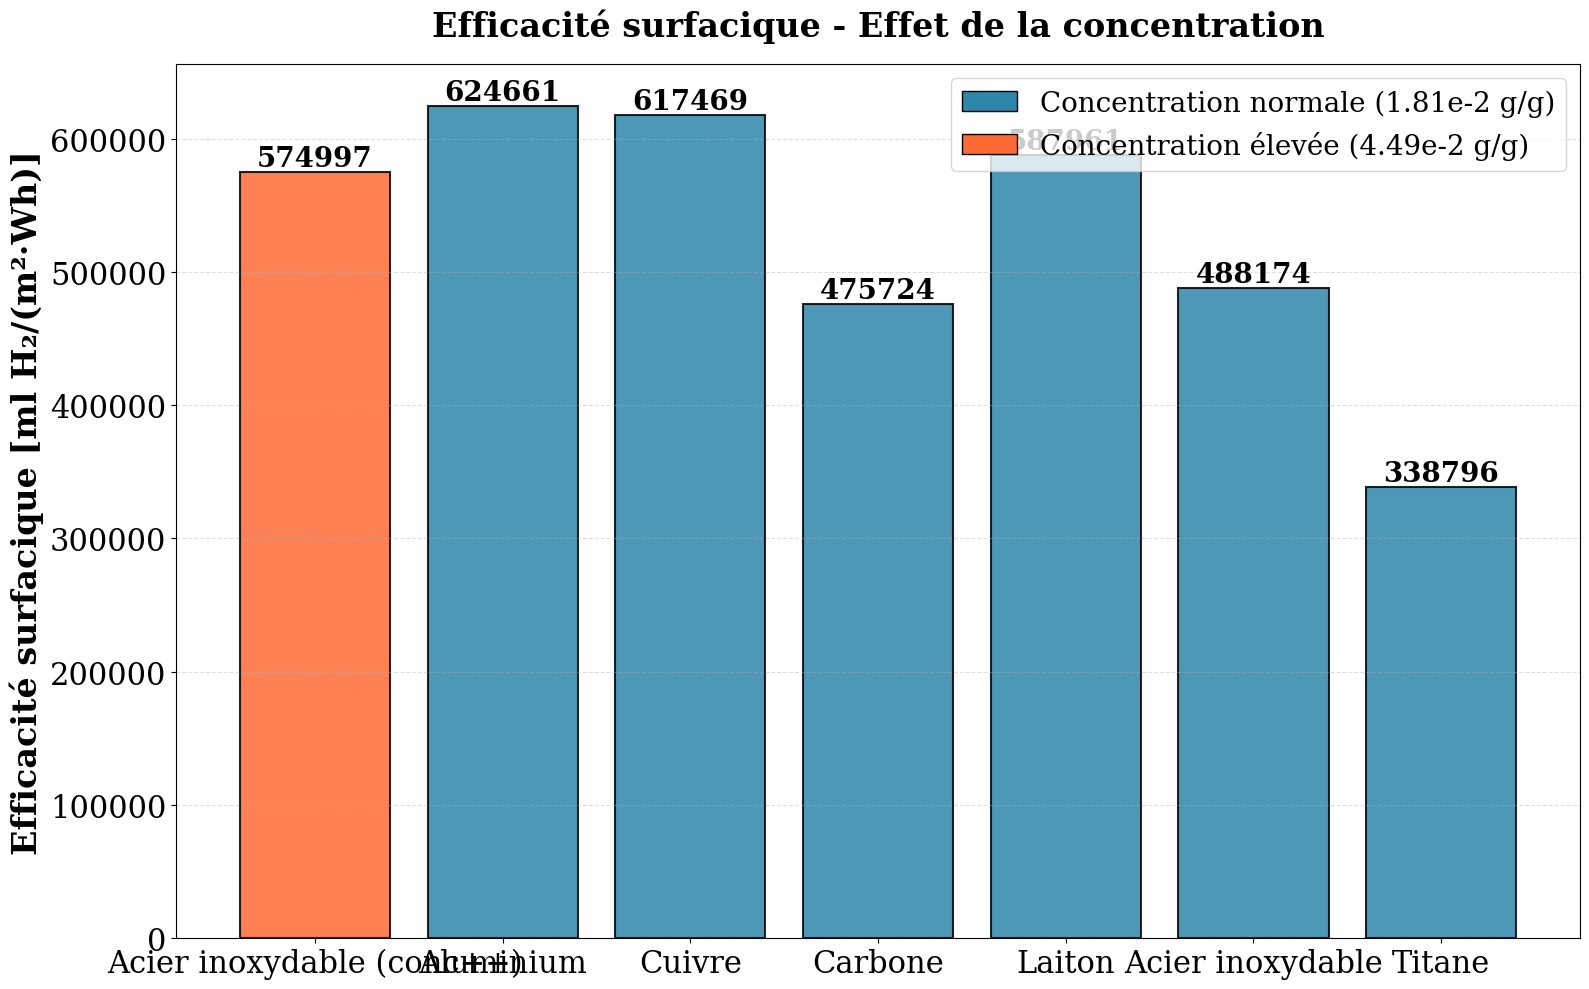


Classification par efficacité surfacique (Analyse 2):
  Acier inoxydable (conc++)      : 574997 ml H₂/(m²·Wh) (concentration élevée)
  Aluminium                      : 624661 ml H₂/(m²·Wh) (concentration normale)
  Cuivre                         : 617469 ml H₂/(m²·Wh) (concentration normale)
  Carbone                        : 475724 ml H₂/(m²·Wh) (concentration normale)
  Laiton                         : 587961 ml H₂/(m²·Wh) (concentration normale)
  Acier inoxydable               : 488174 ml H₂/(m²·Wh) (concentration normale)
  Titane                         : 338796 ml H₂/(m²·Wh) (concentration normale)


In [ ]:
# Graphique 5: Effet de la concentration sur l'efficacité surfacique

fig_a2_5, ax = plt.subplots(figsize=(16, 10))

# Utiliser le tri par efficacité
colors = ['#2E86AB' if conc < 0.03 else '#FF6B35' 
          for conc in df_analyse2_sorted['Concentration NaHCO₃ [g/g]']]

bars = ax.bar(df_analyse2_sorted['Électrodes'], 
              df_analyse2_sorted['Efficacité surfacique [ml H₂/(m²·Wh)]'],
              color=colors, alpha=0.85, edgecolor='black', linewidth=1.5)

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.0f}',
            ha='center', va='bottom', fontsize=20, fontweight='bold')

ax.set_ylabel('Efficacité surfacique [ml H₂/(m²·Wh)]', fontsize=24, fontweight='bold')
ax.set_title('Efficacité surfacique - Effet de la concentration', 
             fontsize=24, fontweight='bold', pad=20)
ax.tick_params(axis='both', labelsize=22)
ax.tick_params(axis='x', rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Légende
ax.legend(handles=legend_elements, loc='upper right', fontsize=20)

plt.tight_layout()
plt.show()

print("\nClassification par efficacité surfacique (Analyse 2):")
for idx, row in df_analyse2_sorted.iterrows():
    conc_label = "élevée" if row['Concentration NaHCO₃ [g/g]'] > 0.03 else "normale"
    print(f"  {row['Électrodes']:30s} : {row['Efficacité surfacique [ml H₂/(m²·Wh)]']:.0f} ml H₂/(m²·Wh) (concentration {conc_label})")

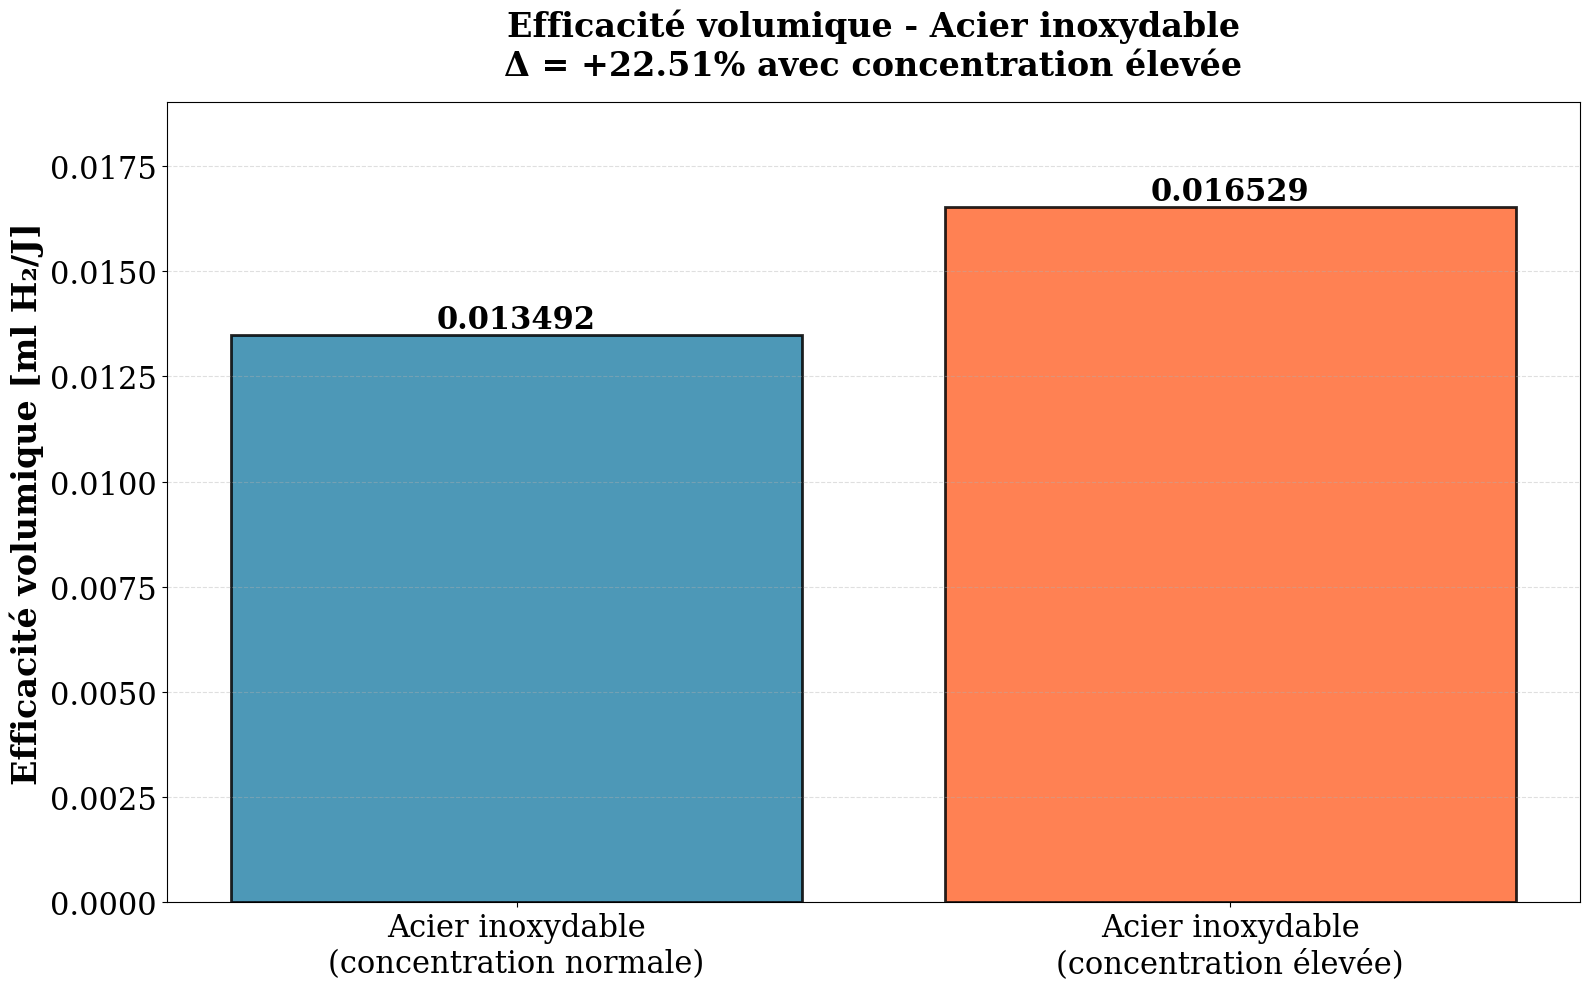


COMPARAISON EFFICACITÉ VOLUMIQUE - ACIER INOXYDABLE
Configuration                            | Concentration [g/g] |  Volume H₂ [ml] |  Énergie [J] | Efficacité vol. [ml/J]
------------------------------------------------------------------------------------------------------------------------
Acier inoxydable (normale)               |           0.018100 |           34.00 |      2520.00 |               0.013492
Acier inoxydable (conc++)                |           0.044928 |           30.00 |      1815.00 |               0.016529

Rapport de concentration: 2.48x
Variation de l'efficacité volumique: +22.51%
Facteur d'efficacité volumique: 1.225x

ANALYSE COMPARATIVE

À concentration normale (1.81e-02 g/g):
  - Production H₂: 34.00 ml
  - Énergie consommée: 2520.00 J
  - Efficacité volumique: 0.013492 ml/J

À concentration élevée (4.49e-02 g/g):
  - Production H₂: 30.00 ml
  - Énergie consommée: 1815.00 J
  - Efficacité volumique: 0.016529 ml/J

Conclusion:
  L'augmentation de la concentr

In [ ]:
# Graphique 6: Comparaison de l'efficacité volumique entre les deux aciers

# Calculer l'efficacité volumique (ml H₂ produit / Joule d'énergie consommée)
# Efficacité volumique = Volume H₂ / Énergie = [ml/J]
df_analyse2['Efficacité volumique [ml H₂/J]'] = df_analyse2['Volume H₂ [ml]'] / df_analyse2['Énergie [J]']

# Calculer l'efficacité énergétique (énergie utile / énergie consommée)
# Efficacité énergétique = (Volume H₂ × E_vol_H2) / Énergie = [J/J] (sans dimension)
df_analyse2['Efficacité énergétique [J/J]'] = (df_analyse2['Volume H₂ [ml]'] * E_vol_H2) / df_analyse2['Énergie [J]']

# Extraire les données des deux aciers
df_acier_normal_vol = df_analyse2[df_analyse2['Électrodes'] == 'Acier inoxydable']
df_acier_conc_vol = df_analyse2[df_analyse2['Électrodes'] == 'Acier inoxydable (conc++)']

fig_a2_6, ax = plt.subplots(figsize=(16, 10))

# Données pour le graphique
electrodes_acier = ['Acier inoxydable\n(concentration normale)', 'Acier inoxydable\n(concentration élevée)']
efficacites_vol = [
    df_acier_normal_vol['Efficacité volumique [ml H₂/J]'].iloc[0],
    df_acier_conc_vol['Efficacité volumique [ml H₂/J]'].iloc[0]
]

bars = ax.bar(electrodes_acier, efficacites_vol,
              color=['#2E86AB', '#FF6B35'], alpha=0.85, 
              edgecolor='black', linewidth=2)

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.6f}',
            ha='center', va='bottom', fontsize=22, fontweight='bold')

# Calculer et afficher la variation
variation = ((efficacites_vol[1] - efficacites_vol[0]) / efficacites_vol[0]) * 100

ax.set_ylabel('Efficacité volumique [ml H₂/J]', fontsize=24, fontweight='bold')
ax.set_title(f'Efficacité volumique - Acier inoxydable\nΔ = {variation:+.2f}% avec concentration élevée', 
             fontsize=24, fontweight='bold', pad=20)
ax.tick_params(axis='both', labelsize=22)
ax.tick_params(axis='x', rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.set_ylim(0, max(efficacites_vol) * 1.15)

plt.tight_layout()
plt.show()

# Tableau récapitulatif détaillé
print("\n" + "="*120)
print("COMPARAISON EFFICACITÉ VOLUMIQUE - ACIER INOXYDABLE")
print("="*120)
print(f"{'Configuration':40s} | {'Concentration [g/g]':>18s} | {'Volume H₂ [ml]':>15s} | {'Énergie [J]':>12s} | {'Efficacité vol. [ml/J]':>22s}")
print("-"*120)

conc_normale_val = df_acier_normal_vol['Concentration NaHCO₃ [g/g]'].iloc[0]
vol_h2_normale = df_acier_normal_vol['Volume H₂ [ml]'].iloc[0]
energie_normale = df_acier_normal_vol['Énergie [J]'].iloc[0]
eff_vol_normale = efficacites_vol[0]

print(f"{'Acier inoxydable (normale)':40s} | {conc_normale_val:>18.6f} | {vol_h2_normale:>15.2f} | {energie_normale:>12.2f} | {eff_vol_normale:>22.6f}")

conc_elevee_val = df_acier_conc_vol['Concentration NaHCO₃ [g/g]'].iloc[0]
vol_h2_elevee = df_acier_conc_vol['Volume H₂ [ml]'].iloc[0]
energie_elevee = df_acier_conc_vol['Énergie [J]'].iloc[0]
eff_vol_elevee = efficacites_vol[1]

print(f"{'Acier inoxydable (conc++)':40s} | {conc_elevee_val:>18.6f} | {vol_h2_elevee:>15.2f} | {energie_elevee:>12.2f} | {eff_vol_elevee:>22.6f}")

print("="*120)
print(f"\nRapport de concentration: {conc_elevee_val / conc_normale_val:.2f}x")
print(f"Variation de l'efficacité volumique: {variation:+.2f}%")
print(f"Facteur d'efficacité volumique: {eff_vol_elevee / eff_vol_normale:.3f}x")
print("="*120)

# Analyse supplémentaire
print("\n" + "="*120)
print("ANALYSE COMPARATIVE")
print("="*120)
print(f"\nÀ concentration normale ({conc_normale_val:.2e} g/g):")
print(f"  - Production H₂: {vol_h2_normale:.2f} ml")
print(f"  - Énergie consommée: {energie_normale:.2f} J")
print(f"  - Efficacité volumique: {eff_vol_normale:.6f} ml/J")

print(f"\nÀ concentration élevée ({conc_elevee_val:.2e} g/g):")
print(f"  - Production H₂: {vol_h2_elevee:.2f} ml")
print(f"  - Énergie consommée: {energie_elevee:.2f} J")
print(f"  - Efficacité volumique: {eff_vol_elevee:.6f} ml/J")

print(f"\nConclusion:")
if variation > 0:
    print(f"  L'augmentation de la concentration améliore l'efficacité volumique de {variation:.2f}%")
else:
    print(f"  L'augmentation de la concentration réduit l'efficacité volumique de {abs(variation):.2f}%")
print("="*120)

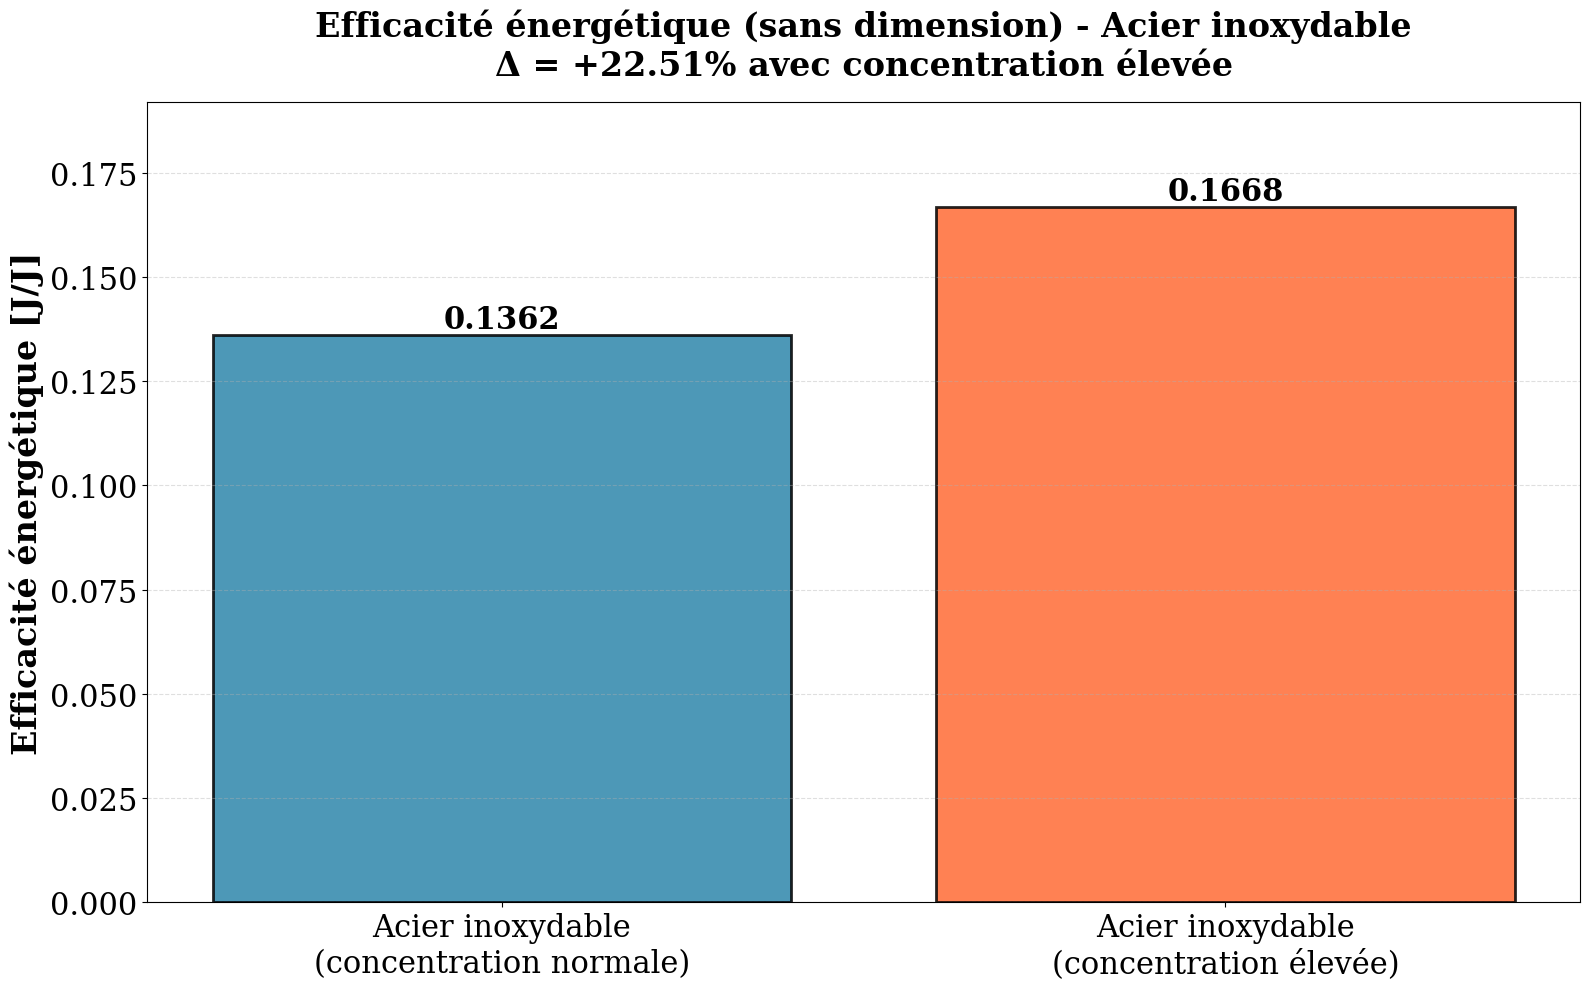


COMPARAISON EFFICACITÉ ÉNERGÉTIQUE [J/J] - ACIER INOXYDABLE
Configuration                            |  Volume H₂ [ml] |  Énergie élec. [J] |  Énergie H₂ [J] |  Efficacité [J/J]
------------------------------------------------------------------------------------------------------------------------
Acier inoxydable (normale)               |           34.00 |            2520.00 |          343.15 |            0.1362
Acier inoxydable (conc++)                |           30.00 |            1815.00 |          302.78 |            0.1668

Constante énergétique H₂: 10.0926 J/ml
Variation de l'efficacité énergétique: +22.51%
Facteur d'efficacité énergétique: 1.225x

ANALYSE COMPARATIVE - EFFICACITÉ ÉNERGÉTIQUE

À concentration normale (1.81e-02 g/g):
  - Énergie électrique consommée: 2520.00 J
  - Énergie chimique produite (H₂): 343.15 J
  - Efficacité énergétique: 0.1362 (13.62%)

À concentration élevée (4.49e-02 g/g):
  - Énergie électrique consommée: 1815.00 J
  - Énergie chimique produite (H

In [ ]:
# Graphique 7: Comparaison de l'efficacité énergétique [J/J] entre les deux aciers

fig_a2_7, ax = plt.subplots(figsize=(16, 10))

# Données pour le graphique
efficacites_energ = [
    df_acier_normal_vol['Efficacité énergétique [J/J]'].iloc[0],
    df_acier_conc_vol['Efficacité énergétique [J/J]'].iloc[0]
]

bars = ax.bar(electrodes_acier, efficacites_energ,
              color=['#2E86AB', '#FF6B35'], alpha=0.85, 
              edgecolor='black', linewidth=2)

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=22, fontweight='bold')

# Calculer et afficher la variation
variation_energ = ((efficacites_energ[1] - efficacites_energ[0]) / efficacites_energ[0]) * 100

ax.set_ylabel('Efficacité énergétique [J/J]', fontsize=24, fontweight='bold')
ax.set_title(f'Efficacité énergétique (sans dimension) - Acier inoxydable\nΔ = {variation_energ:+.2f}% avec concentration élevée', 
             fontsize=24, fontweight='bold', pad=20)
ax.tick_params(axis='both', labelsize=22)
ax.tick_params(axis='x', rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.set_ylim(0, max(efficacites_energ) * 1.15)

plt.tight_layout()
plt.show()

# Tableau récapitulatif détaillé
print("\n" + "="*120)
print("COMPARAISON EFFICACITÉ ÉNERGÉTIQUE [J/J] - ACIER INOXYDABLE")
print("="*120)
print(f"{'Configuration':40s} | {'Volume H₂ [ml]':>15s} | {'Énergie élec. [J]':>18s} | {'Énergie H₂ [J]':>15s} | {'Efficacité [J/J]':>17s}")
print("-"*120)

energie_h2_normale = vol_h2_normale * E_vol_H2
eff_energ_normale = efficacites_energ[0]

print(f"{'Acier inoxydable (normale)':40s} | {vol_h2_normale:>15.2f} | {energie_normale:>18.2f} | {energie_h2_normale:>15.2f} | {eff_energ_normale:>17.4f}")

energie_h2_elevee = vol_h2_elevee * E_vol_H2
eff_energ_elevee = efficacites_energ[1]

print(f"{'Acier inoxydable (conc++)':40s} | {vol_h2_elevee:>15.2f} | {energie_elevee:>18.2f} | {energie_h2_elevee:>15.2f} | {eff_energ_elevee:>17.4f}")

print("="*120)
print(f"\nConstante énergétique H₂: {E_vol_H2} J/ml")
print(f"Variation de l'efficacité énergétique: {variation_energ:+.2f}%")
print(f"Facteur d'efficacité énergétique: {eff_energ_elevee / eff_energ_normale:.3f}x")
print("="*120)

# Analyse comparative
print("\n" + "="*120)
print("ANALYSE COMPARATIVE - EFFICACITÉ ÉNERGÉTIQUE")
print("="*120)
print(f"\nÀ concentration normale ({conc_normale_val:.2e} g/g):")
print(f"  - Énergie électrique consommée: {energie_normale:.2f} J")
print(f"  - Énergie chimique produite (H₂): {energie_h2_normale:.2f} J")
print(f"  - Efficacité énergétique: {eff_energ_normale:.4f} ({eff_energ_normale*100:.2f}%)")

print(f"\nÀ concentration élevée ({conc_elevee_val:.2e} g/g):")
print(f"  - Énergie électrique consommée: {energie_elevee:.2f} J")
print(f"  - Énergie chimique produite (H₂): {energie_h2_elevee:.2f} J")
print(f"  - Efficacité énergétique: {eff_energ_elevee:.4f} ({eff_energ_elevee*100:.2f}%)")

print(f"\nConclusion:")
if variation_energ > 0:
    print(f"  L'augmentation de la concentration améliore l'efficacité énergétique de {variation_energ:.2f}%")
else:
    print(f"  L'augmentation de la concentration réduit l'efficacité énergétique de {abs(variation_energ):.2f}%")
print(f"  L'efficacité énergétique représente le rapport entre l'énergie chimique du H₂ produit")
print(f"  et l'énergie électrique consommée (valeur idéale = 1.00 ou 100%)")
print("="*120)

%Make a table that resumate all the data. 
% Current
% Power
% Volume H_2
% Volume O_2
% Efficacité énergétique
% efficacité surfacique



## Analyse globale : Efficacité énergétique de toutes les électrodes

Comparaison de l'efficacité énergétique [J/J] pour toutes les configurations testées.

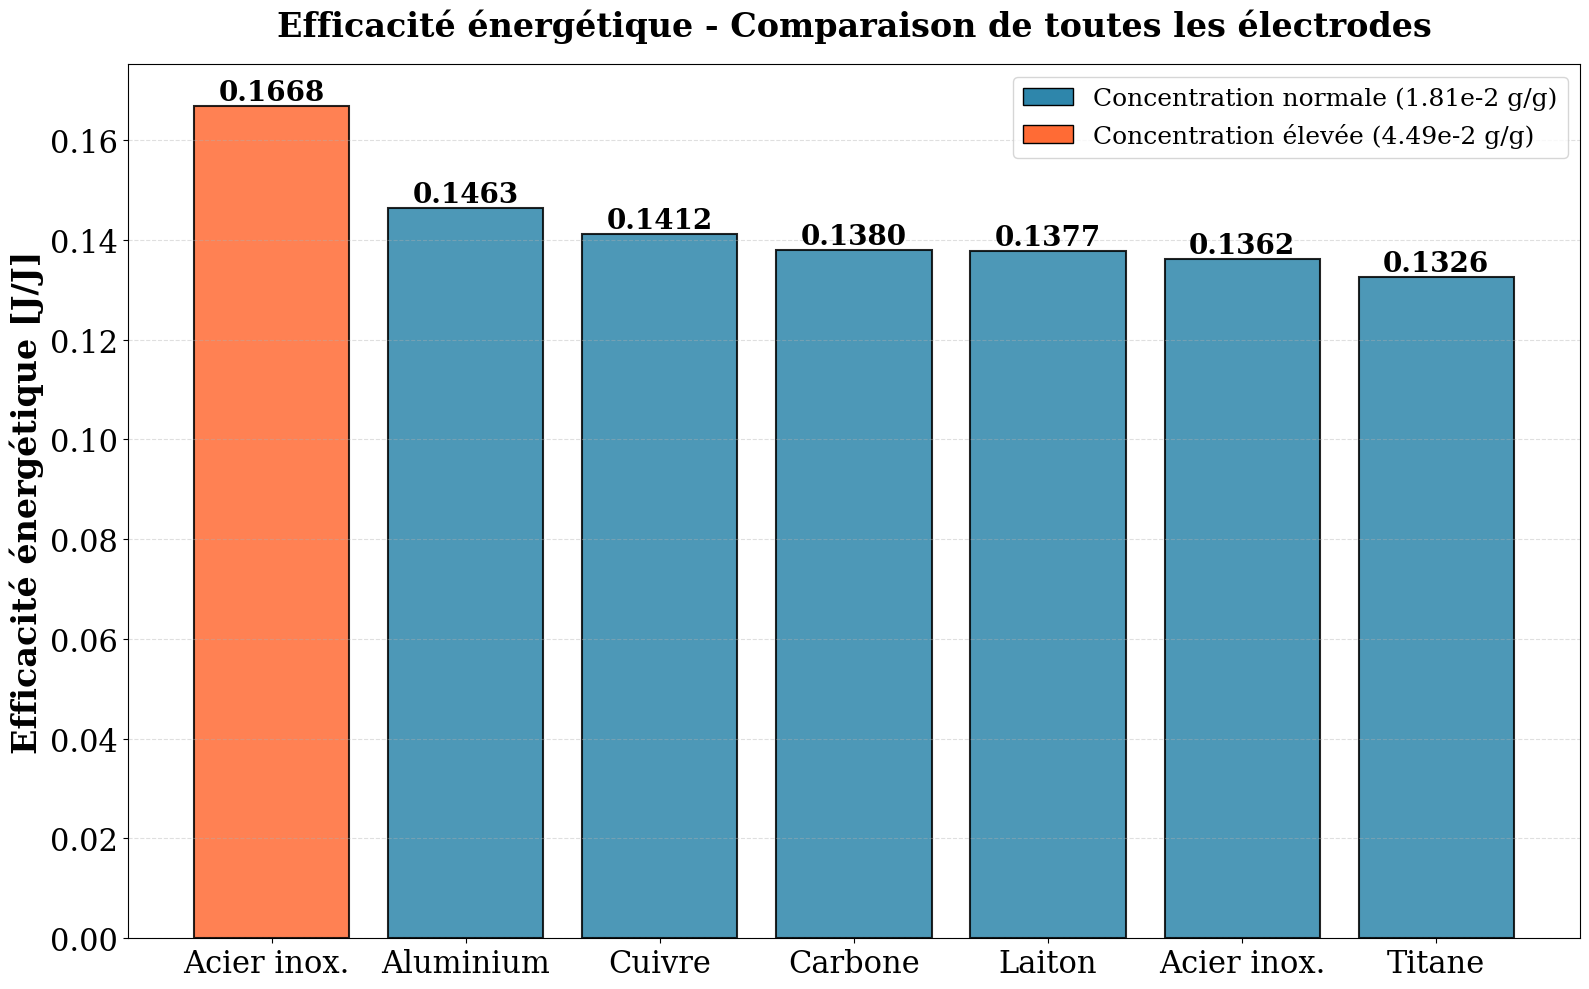


CLASSEMENT GLOBAL PAR EFFICACITÉ ÉNERGÉTIQUE [J/J]
 Rang | Électrode                      | Concentration [g/g] |  Volume H₂ [ml] |  Énergie élec. [J] |  Énergie H₂ [J] |  Efficacité [J/J]
--------------------------------------------------------------------------------------------------------------------------------------------
    1 | Acier inoxydable (conc++)      |           0.044928 |           30.00 |            1815.00 |          302.78 |            0.1668
    2 | Aluminium                      |           0.018100 |           41.00 |            2828.55 |          413.80 |            0.1463
    3 | Cuivre                         |           0.018100 |           40.00 |            2860.00 |          403.70 |            0.1412
    4 | Carbone                        |           0.018100 |           32.00 |            2340.00 |          322.96 |            0.1380
    5 | Laiton                         |           0.018100 |           42.00 |            3078.40 |          423.89 |   

In [ ]:
# Graphique final: Efficacité énergétique [J/J] pour toutes les électrodes

# Calculer l'efficacité énergétique pour toutes les électrodes (Analyse 2)
# Si non déjà calculé, l'ajouter
if 'Efficacité énergétique [J/J]' not in df_analyse2.columns:
    df_analyse2['Efficacité énergétique [J/J]'] = (df_analyse2['Volume H₂ [ml]'] * E_vol_H2) / df_analyse2['Énergie [J]']

# Trier par efficacité énergétique
df_final_sorted = df_analyse2.sort_values('Efficacité énergétique [J/J]', ascending=False)

# Créer des labels uniques en ajoutant un suffixe invisible pour éviter la superposition
electrodes_labels_final = []
for idx, row in df_final_sorted.iterrows():
    if row['Électrodes'] == 'Acier inoxydable (conc++)':
        electrodes_labels_final.append('Acier inox. ')  # Espace à la fin pour différencier
    elif row['Électrodes'] == 'Acier inoxydable':
        electrodes_labels_final.append('Acier inox.')
    else:
        electrodes_labels_final.append(row['Électrodes'])

fig_final, ax = plt.subplots(figsize=(16, 10))

# Créer les barres avec des couleurs différentes pour les concentrations
colors_final = ['#2E86AB' if conc < 0.03 else '#FF6B35' 
                for conc in df_final_sorted['Concentration NaHCO₃ [g/g]']]

bars = ax.bar(electrodes_labels_final, 
              df_final_sorted['Efficacité énergétique [J/J]'],
              color=colors_final, alpha=0.85, edgecolor='black', linewidth=1.5)

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=20, fontweight='bold')

ax.set_ylabel('Efficacité énergétique [J/J]', fontsize=24, fontweight='bold')
ax.set_title('Efficacité énergétique - Comparaison de toutes les électrodes', 
             fontsize=24, fontweight='bold', pad=20)
ax.tick_params(axis='both', labelsize=22)
ax.tick_params(axis='x', rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Légende pour les concentrations
from matplotlib.patches import Patch
legend_elements_final = [
    Patch(facecolor='#2E86AB', edgecolor='black', label='Concentration normale (1.81e-2 g/g)'),
    Patch(facecolor='#FF6B35', edgecolor='black', label='Concentration élevée (4.49e-2 g/g)')
]
ax.legend(handles=legend_elements_final, loc='upper right', fontsize=18)

plt.tight_layout()
plt.show()

# Tableau récapitulatif complet
print("\n" + "="*140)
print("CLASSEMENT GLOBAL PAR EFFICACITÉ ÉNERGÉTIQUE [J/J]")
print("="*140)
print(f"{'Rang':>5s} | {'Électrode':30s} | {'Concentration [g/g]':>18s} | {'Volume H₂ [ml]':>15s} | {'Énergie élec. [J]':>18s} | {'Énergie H₂ [J]':>15s} | {'Efficacité [J/J]':>17s}")
print("-"*140)

for i, (idx, row) in enumerate(df_final_sorted.iterrows(), 1):
    electrode = row['Électrodes']
    conc = row['Concentration NaHCO₃ [g/g]']
    vol_h2 = row['Volume H₂ [ml]']
    energie_elec = row['Énergie [J]']
    energie_h2 = vol_h2 * E_vol_H2
    eff_energ = row['Efficacité énergétique [J/J]']
    
    print(f"{i:>5d} | {electrode:30s} | {conc:>18.6f} | {vol_h2:>15.2f} | {energie_elec:>18.2f} | {energie_h2:>15.2f} | {eff_energ:>17.4f}")

print("="*140)

# Statistiques globales
print("\n" + "="*140)
print("STATISTIQUES GLOBALES")
print("="*140)
print(f"\nConstante énergétique H₂: {E_vol_H2} J/ml")
print(f"\nEfficacité énergétique moyenne: {df_final_sorted['Efficacité énergétique [J/J]'].mean():.4f} ({df_final_sorted['Efficacité énergétique [J/J]'].mean()*100:.2f}%)")
print(f"Efficacité énergétique médiane: {df_final_sorted['Efficacité énergétique [J/J]'].median():.4f} ({df_final_sorted['Efficacité énergétique [J/J]'].median()*100:.2f}%)")
print(f"Écart-type: {df_final_sorted['Efficacité énergétique [J/J]'].std():.4f}")
print(f"Meilleure efficacité: {df_final_sorted['Efficacité énergétique [J/J]'].max():.4f} ({df_final_sorted['Efficacité énergétique [J/J]'].max()*100:.2f}%) - {df_final_sorted.iloc[0]['Électrodes']}")
print(f"Pire efficacité: {df_final_sorted['Efficacité énergétique [J/J]'].min():.4f} ({df_final_sorted['Efficacité énergétique [J/J]'].min()*100:.2f}%) - {df_final_sorted.iloc[-1]['Électrodes']}")

print("\n" + "="*140)
print("INTERPRÉTATION")
print("="*140)
print("L'efficacité énergétique [J/J] représente le rapport entre l'énergie chimique stockée")
print("dans l'hydrogène produit et l'énergie électrique consommée pour l'électrolyse.")
print("\nValeurs typiques:")
print("  - 1.00 (100%) : Efficacité théorique maximale (conversion parfaite)")
print("  - 0.50-0.80 : Efficacité réaliste pour l'électrolyse de l'eau")
print("  - < 0.50 : Efficacité faible, pertes importantes")
print("="*140)